In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import pytest
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import soec_standalone_flowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = soec_standalone_flowsheet.SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:33:29 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")
# m.fs.initialize_build(outlvl=idaeslog.DEBUG)

2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Starting initialization
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Starting initialization
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side.properties_out: Property initialization: optimal - Optimal Solution Found.
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.hot_side: Initialization Complete
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Starting initialization
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_in: Property initialization: optimal - Optimal Solution Found.
2022-12-08 13:33:42 [INFO] idaes.init.fs.sweep_hot_exchanger.cold_side.properties_out: Starting initialization
2022-12-08 13:33:42 [INFO] idae

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash02.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-08 13:34:48 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

In [9]:
assert dof(m) == 0
solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpzmx8z1pc_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpzmx8z1pc_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2498, 'Number of variables': 2498, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 7.332038640975952}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = 10*(  # Random factor makes IPOPT converge this time
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    m.fs.max_raw_water_withdrawal_eqn.deactivate()
    m.fs.feed_heater.costing.max_heat_duty_eqn.deactivate()
    m.fs.sweep_heater.costing.max_heat_duty_eqn.deactivate()
    m.fs.heat_pump.costing.max_heat_duty_eqn.deactivate()
    
    m.fs.max_raw_water_withdrawal_ineq.activate()
    m.fs.feed_heater.costing.max_heat_duty_ineq.activate()
    m.fs.sweep_heater.costing.max_heat_duty_ineq.activate()
    m.fs.heat_pump.costing.max_heat_duty_ineq.activate()
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    @m.fs.Constraint(m.fs.time)
    def water_evaporator02_vapor_out_ineq(b,t):
        try:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Vap","Liq"]
        except KeyError:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Liq","Vap"]
        return (
            b.water_evaporator02.shell.properties_out[t].temperature 
            >= tdew
        )
    iscale.constraint_scaling_transform(m.fs.water_evaporator02_vapor_out_ineq[0], 1e-2)
    
    
    for cmp in [m.fs.sweep_blower, m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        set_indexed_variable_bounds(cmp.work_mechanical, (0, None))
    set_indexed_variable_bounds(m.fs.water_compressor.control_volume.work, (0, None))
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.6))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (550+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-10400,5200))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    m.fs.feed_heater.costing.max_heat_duty.set_value(8e6)
    m.fs.sweep_heater.costing.max_heat_duty.set_value(8e6)
    m.fs.feed_heater.costing.max_heat_duty.bounds = (8e6, None)
    m.fs.sweep_heater.costing.max_heat_duty.bounds = (8e6, None)
    #m.fs.heat_pump.costing.max_heat_duty.fix(2e7)
    m.fs.max_raw_water_withdrawal.fix(3000)
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
        set_indexed_variable_bounds(cmp.outlet.temperature, (273.15, 250+273.15))
    
    m.fs._make_temperature_gradient_terms()
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_electrode.dtemperature_dz, (-750, 750))
    m.fs.make_performance_constraints()
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1705)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1708)


In [11]:
m.fs.h2_mass_production.fix(5)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpfpjsnnit_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpfpjsnnit_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  68  5.4082908e+03 2.64e-01 1.74e+05  -5.7 6.67e-01   1.2 1.24e-01 1.90e-02h  1
  69  5.4090677e+03 1.47e-01 2.90e+08  -5.7 8.79e-01   0.7 2.13e-06 4.45e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.4100126e+03 1.07e-02 2.72e+04  -5.7 4.99e-01   0.2 2.69e-01 1.00e+00h  1
  71  5.4098017e+03 2.24e-03 1.16e+03  -5.7 2.06e-01  -0.3 1.00e+00 1.00e+00f  1
  72  5.4091911e+03 2.05e-02 2.76e+03  -5.7 5.40e-01  -0.7 1.00e+00 1.00e+00f  1
  73  5.4092093e+03 1.16e-04 6.52e+03  -5.7 2.12e-02   1.9 1.93e-01 1.00e+00h  1
  74  5.4092093e+03 1.15e-04 2.15e+04  -5.7 5.43e-03   1.4 1.00e+00 2.46e-03h  1
  75  5.4092062e+03 1.14e-05 3.46e+01  -5.7 1.12e-02   1.0 1.00e+00 1.00e+00f  1
  76  5.4091732e+03 9.63e-05 3.09e+01  -5.7 3.20e-02   0.5 1.00e+00 1.00e+00f  1
  77  5.4090766e+03 7.77e-04 1.43e+01  -5.7 9.23e-02   0.0 1.00e+00 1.00e+00f  1
  78  5.4088044e+03 4.93e-03 5.92e+00  -5.7 2.47e-01  -0.5 1.00e+00 1.00e+00f  1
  79  5.4088043e+03 1.87e-05

 161  5.3279425e+03 2.02e-02 5.25e+05  -5.7 2.63e+03  -3.5 1.62e-03 5.71e-07f  1
 162  5.3275599e+03 2.01e-02 5.11e+05  -5.7 2.25e+02  -4.0 1.85e-01 6.49e-03f  1
 163  5.3259876e+03 4.71e-02 4.85e+05  -5.7 4.01e+02  -4.5 1.31e-01 2.01e-02f  1
 164  5.3257898e+03 4.68e-02 4.58e+05  -5.7 2.94e+02    -  2.04e-01 7.60e-03f  1
 165  5.3257420e+03 4.66e-02 4.55e+05  -5.7 4.30e+02    -  2.67e-01 6.56e-03f  1
 166  5.3231726e+03 2.85e-01 2.31e+05  -5.7 1.41e+01    -  3.21e-01 4.94e-01f  1
 167  5.3231219e+03 2.39e-01 1.91e+05  -5.7 2.75e+00  -1.3 6.24e-01 1.63e-01h  1
 168  5.3226062e+03 2.26e-01 1.37e+05  -5.7 5.76e+00  -1.8 2.46e-01 2.86e-01h  1
 169  5.3191020e+03 2.55e+00 1.53e+05  -5.7 4.70e+01    -  5.30e-02 2.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  5.3192210e+03 2.39e+00 5.75e+09  -5.7 3.71e+00    -  6.83e-01 6.15e-02h  1
 171  5.3203598e+03 1.27e+00 5.52e+10  -5.7 2.35e+00    -  5.74e-03 5.38e-01h  1
 172  5.3211823e+03 4.41e-01

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2534, 'Number of variables': 2536, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 47.189871311187744}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
print(pyo.value(m.fs.soec_module.solid_oxide_cell.average_current_density[0]))
print(pyo.value((m.fs.obj)*1e5/(5*m.fs.costing.plant_uptime)))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2959059693 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower  : Value               : Upper : Fixed : Stale : Domain
     (0.0, 1) : -10400 :  -8552.481102960728 :  5200 : False : False :  Reals
     (0.0, 2) : -10400 :  -9872.858865664479 :  5200 : False : False :  Reals
     (0.0, 3) : -10400 :            -10400.0 :  5200 : False : False :  Reals
     (0.0, 4) : -10400 : -10146.127669425234 :  5200 : False : False :  Reals
     (0.0, 5) : -10400 :  -9367.403147507512 :  5200 : False : False :  Reals
     (0.0, 6) : -10400 :  -8331.578729899657 :  5200 : False : False :  Reals
     (0.0, 7) : -10400 :  -7240.200662163133 :  5200 : False : False :  Reals
     (0.0, 8) : -10400 :  -6214.108854141321 :  5200 : False : Fa

In [13]:
display_soec_costing(m.fs)

Capital cost: $439M
Fixed O&M cost: $26.1M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


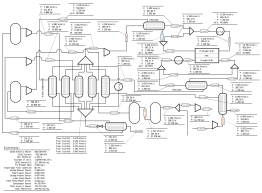

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,837.804026,100.0,179.843508
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,837.804026,NaN,179.816147
feed03,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,893.356797,NaN,383.734354
feed04,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,929.128108,NaN,399.115452
hstrm01,32.33988,6.200397,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,413.414799
hstrm02,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707404
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707395
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,546.975234,NaN,117.492387
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,372.211568,NaN,79.912983


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
                 m.fs.product_flash02,
                 m.fs.product_flash03, m.fs.product_flash04]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

# tpc = pyo.value(m.fs.costing.total_TPC)
# tasc = tpc*1.21*1.093
# ac = tasc*0.0707
assert pyo.value(m.fs.costing.total_TPC) == pytest.approx(439.5608, rel=1e-3)
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
assert pyo.value(m.fs.costing.total_annualized_cost) == pytest.approx(41.100, rel=1e-3)
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

# Parameters
# n_op = 6.3
# hourly_rate = 38.50
# labor_burden = 30

# Fixed O&M components
# annual_op_labor = n_op * hourly_rate * 8760 * (1 - labor_burden/100)/1e6
# maint_labor = tpc * 0.4 * 0.019 
# maint_material = tpc * 0.6 * 0.019
# admin_labor = 0.25*(annual_op_labor + maint_labor)
# prop_tax_ins = 0.02*tpc
# soec_replace = pyo.value(4.2765*m.fs.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $439.37MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $25.80MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $25.18MM
Contribution from gas-gas exchangers: $16.46MM
Contribution from gas-water exchangers: $32.88MM
Contribution from flash vessels: $0.45MM
Contribution from heat pump: $34.77MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $31.12MM
Contribution from accessory electric equipment: $93.02MM
Contribution from instrumentation and controls: $23.19MM
Contribution from improvements to site: $27.48MM
Contribution from buildings and structures: $7.34MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 439.3737992635775
TASC = 581.0850307400592
Annualized TASC (MM$/yr) = 41.08271167332219
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.339240874403189
maint_mate

In [18]:
assert m.fs.tags_output['total_electric_power_per_h2'].value == pytest.approx(143.998, rel=1e-3)
assert m.fs.tags_input['water_utilization'].value == pytest.approx(66.667, rel=1e-3)

In [19]:
print(m.fs.tags_output['total_electric_power_per_h2'].value)
print(m.fs.tags_input['water_utilization'].value)
m.fs.soec_module.number_cells.pprint()

143.95130635510205
66.66666761317457
number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2959059693 :  None : False : False :  Reals


In [20]:
for hx in water_heaters + cross_flow_exchangers:
    print(f"{hx.name}: {pyo.value(hx.area)}")

fs.water_evaporator01: 2018.379042695468
fs.water_evaporator02: 1632.3364134677527
fs.water_evaporator03: 1513.6695047822025
fs.water_evaporator04: 5245.845311498834
fs.water_evaporator05: 5267.225785613446
fs.water_preheater: 1746.1142437295653
fs.feed_hot_exchanger: 4639.91745769366
fs.sweep_hot_exchanger: 5522.146624543348
fs.sweep_medium_exchanger: 8511.836587485945


In [21]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()

for hx in water_heaters + cross_flow_exchangers:
    hx.area.fix()

for heater in heaters:
    heater.costing.max_heat_duty.fix()
    
m.fs.soec_module.number_cells.fix()
m.fs.max_raw_water_withdrawal.fix()
m.fs.heat_pump.costing.max_heat_duty.fix()

m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = 10*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  

In [22]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

# This solve is going to fail due to maximum iterations. However, I know that we can change the objective function and then
# successfully 
try:
    if run_samples:
        i=1
        df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
        for prod in prod_vec:
            print(prod)
            m.fs.h2_mass_production.fix(prod)
            res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
            assert res.solver.termination_condition == pyo.TerminationCondition.optimal
            assert res.solver.status == pyo.SolverStatus.ok
            df.loc[i] = m.fs.tags_output.table_row(numeric=True)
            i += 1
except AssertionError:
    pass

5.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpkiv2lma3_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpkiv2lma3_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

  64  4.6498821e+03 4.09e-05 5.40e+05  -1.0 1.89e+02    -  9.10e-01 7.17e-03h  8
  65  4.6498819e+03 4.07e-05 5.67e+05  -1.0 1.90e+02    -  4.86e-01 7.10e-03h  8
  66  4.6498816e+03 4.07e-05 6.28e+05  -1.0 1.81e+02    -  9.81e-01 7.22e-03h  8
  67  4.6498815e+03 4.04e-05 6.58e+05  -1.0 1.79e+02    -  5.23e-01 7.13e-03h  8
  68  4.6498812e+03 4.04e-05 7.20e+05  -1.0 1.72e+02    -  1.00e+00 7.24e-03h  8
  69  4.6498809e+03 3.98e-05 7.50e+05  -1.0 1.68e+02    -  6.06e-01 1.44e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.6498807e+03 3.98e-05 8.12e+05  -1.0 1.60e+02    -  1.00e+00 7.27e-03h  8
  71  4.6498803e+03 3.94e-05 8.51e+05  -1.0 1.54e+02    -  7.43e-01 1.45e-02h  7
  72  4.6498800e+03 3.99e-05 9.08e+05  -1.0 1.45e+02    -  1.00e+00 1.46e-02h  7
  73  4.6498617e+03 2.01e-03 5.97e+04  -1.0 1.37e+02    -  9.28e-01 9.34e-01w  1
  74  4.6498895e+03 7.20e-04 3.37e+04  -1.0 1.33e+02    -  7.95e-01 8.05e-01w  1
  75  4.6498870e+03 1.83e-03

 157  4.6498846e+03 4.13e-05 2.91e+13  -1.0 6.16e+01    -  1.00e+00 2.01e-02h  6
 158  4.6498847e+03 4.14e-05 4.43e+13  -1.0 6.20e+01    -  1.00e+00 2.03e-02h  6
 159  4.6498847e+03 4.17e-05 6.69e+13  -1.0 6.23e+01    -  1.00e+00 2.05e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.6498875e+03 1.14e-03 3.45e+13  -1.0 6.25e+01    -  1.00e+00 6.62e-01w  1
 161  4.6498913e+03 3.58e-03 8.96e+14  -1.0 7.37e+01    -  9.03e-02 8.56e-01w  1
 162  4.6498906e+03 2.53e-03 6.24e+14  -1.0 9.08e+00    -  3.05e-01 3.04e-01w  1
 163  4.6498848e+03 4.19e-05 1.00e+14  -1.0 1.44e+01    -  1.00e+00 2.07e-02h  5
 164  4.6498849e+03 4.17e-05 1.49e+14  -1.0 6.27e+01    -  1.00e+00 1.05e-02h  7
 165  4.6498850e+03 4.20e-05 2.17e+14  -1.0 6.18e+01    -  1.00e+00 2.11e-02h  6
 166  4.6498850e+03 4.19e-05 3.18e+14  -1.0 6.26e+01    -  1.00e+00 1.06e-02h  7
 167  4.6498850e+03 4.17e-05 4.59e+14  -1.0 6.15e+01    -  1.00e+00 1.08e-02h  7
 168  4.6498851e+03 4.16e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250  4.6499316e+03 6.07e-04 7.91e+04  -1.0 5.92e+01    -  1.00e+00 1.78e-03h 10
 251  4.6499316e+03 6.07e-04 1.04e+05  -1.0 6.62e+01    -  1.00e+00 4.46e-04h 12
 252  4.6499316e+03 6.07e-04 1.30e+05  -1.0 6.96e+01    -  1.00e+00 2.24e-04h 13
 253  4.6499316e+03 6.07e-04 1.55e+05  -1.0 7.10e+01    -  1.00e+00 5.60e-05h 15
 254  4.6498906e+03 5.83e-05 1.27e+05  -1.0 7.14e+01    -  1.00e+00 9.24e-01H  1
 255  4.6498900e+03 6.75e-05 7.72e+05  -1.0 4.96e+01    -  1.00e+00 8.39e-02h  3
 256  4.6498879e+03 6.59e-05 1.20e+06  -1.0 1.55e+01    -  1.00e+00 4.47e-01h  1
 257  4.6498878e+03 7.20e-05 1.17e+07  -1.0 2.93e+01    -  1.00e+00 1.83e-01h  1
 258  4.6498878e+03 7.07e-05 1.11e+09  -1.0 1.53e+01    -  1.00e+00 1.80e-02h  1
 259  4.6498878e+03 6.83e-05 3.83e+10  -1.0 1.17e+01    -  1.00e+00 3.53e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260  4.6498878e+03 6.83e-05

 342  4.6498808e+03 5.01e-05 1.38e+08  -1.0 4.90e+01    -  1.00e+00 4.55e-02h  5
 343  4.6498810e+03 4.93e-05 1.91e+08  -1.0 4.82e+01    -  1.00e+00 4.50e-02h  5
 344  4.6498812e+03 4.86e-05 2.68e+08  -1.0 4.76e+01    -  1.00e+00 4.44e-02h  5
 345  4.6498846e+03 3.80e-04 1.19e+08  -1.0 4.71e+01    -  1.00e+00 7.01e-01w  1
 346  4.6498848e+03 3.66e-04 9.55e+09  -1.0 4.49e+01    -  1.00e+00 4.29e-02w  1
 347  4.6498848e+03 3.64e-04 2.44e+12  -1.0 7.65e+00  -4.5 1.00e+00 4.17e-03w  1
 348  4.6498815e+03 4.79e-05 3.80e+08  -1.0 2.74e+01    -  1.00e+00 4.38e-02h  4
 349  4.6498817e+03 4.72e-05 5.47e+08  -1.0 4.67e+01    -  1.00e+00 4.33e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350  4.6498819e+03 4.66e-05 7.97e+08  -1.0 4.66e+01    -  1.00e+00 4.27e-02h  5
 351  4.6498820e+03 4.61e-05 1.18e+09  -1.0 4.66e+01    -  1.00e+00 4.22e-02h  5
 352  4.6498822e+03 4.56e-05 1.76e+09  -1.0 4.67e+01    -  1.00e+00 4.17e-02h  5
 353  4.6498824e+03 4.52e-05

 435  4.6498866e+03 4.15e-05 9.32e+15  -1.0 7.31e+01    -  1.00e+00 7.74e-03h  8
 436  4.6498907e+03 4.28e-03 8.40e+13  -1.0 7.36e+01    -  1.00e+00 9.90e-01w  1
 437  4.6498911e+03 3.27e-03 1.21e+16  -1.0 1.61e+01    -  1.21e-01 2.40e-01w  1
 438  4.6498918e+03 1.86e-03 6.68e+15  -1.0 1.65e+01    -  3.13e-01 4.51e-01w  1
 439  4.6498866e+03 4.14e-05 8.54e+15  -1.0 2.10e+00    -  1.00e+00 7.74e-03h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  4.6498867e+03 4.13e-05 7.73e+15  -1.0 7.42e+01    -  1.00e+00 7.74e-03h  8
 441  4.6498867e+03 4.13e-05 6.88e+15  -1.0 7.50e+01    -  1.00e+00 7.74e-03h  8
 442  4.6498867e+03 4.13e-05 6.02e+15  -1.0 7.60e+01    -  1.00e+00 7.74e-03h  8
 443  4.6498868e+03 4.12e-05 5.17e+15  -1.0 7.74e+01    -  1.00e+00 7.74e-03h  8
 444  4.6498868e+03 4.12e-05 4.36e+15  -1.0 7.90e+01    -  1.00e+00 7.55e-03h  8
 445  4.6498868e+03 4.12e-05 3.61e+15  -1.0 8.05e+01    -  1.00e+00 7.38e-03h  8
 446  4.6498869e+03 4.12e-05

In [23]:
m.fs.obj2 = pyo.Objective(
        expr = 0.1*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  

    'pyomo.core.base.objective.ScalarObjective'>) on block fs with a new
    Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [24]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 500, "halt_on_ampl_error":"no"})
        assert res.solver.termination_condition == pyo.TerminationCondition.optimal
        assert res.solver.status == pyo.SolverStatus.ok
        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1

5.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpttm4cq3p_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpttm4cq3p_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

   2  4.5450900e+01 7.56e-02 1.71e+01  -1.0 2.66e+02    -  3.42e-01 7.66e-01h  1
   3  4.5406550e+01 4.41e-02 2.69e+01  -1.0 1.58e+02    -  6.14e-01 4.18e-01h  1
   4  4.5357410e+01 4.57e-03 6.56e+01  -1.0 1.23e+02    -  9.16e-01 9.89e-01h  1
   5  4.5353842e+01 2.90e-03 1.94e+02  -1.0 1.15e+02    -  9.90e-01 9.86e-01h  1
   6  4.5353196e+01 4.77e-05 1.85e+03  -1.0 1.62e+01    -  9.90e-01 9.90e-01h  1
   7  4.5353170e+01 6.84e-07 3.49e+05  -1.0 3.96e-01    -  9.91e-01 9.93e-01h  1
   8  4.5353206e+01 1.03e-06 2.62e+06  -1.0 1.13e+00    -  1.00e+00 1.00e+00H  1
   9  4.5353196e+01 1.23e-09 1.95e+06  -1.0 1.58e-02  -2.0 1.00e+00 1.00e+00H  1
Reallocating memory for MA57: lfact (263553)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5353200e+01 2.33e-08 3.95e+02  -1.0 1.69e-03  -0.7 1.00e+00 1.00e+00h  1
  11  4.5353193e+01 8.43e-10 7.21e+07  -5.7 1.31e-03  -0.2 9.98e-01 1.00e+00h  1
  12  4.5353146e+01 2.43e-07 6.28e+01  -5.7 6.67e-03  -0.7 1.00e

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  4.4175732e+01 3.97e-02 1.50e+04  -5.7 5.40e+02    -  4.79e-03 5.91e-02h  1
  21  4.4175715e+01 3.96e-02 8.55e+03  -5.7 3.13e+01  -6.1 7.75e-01 2.01e-03h  1
  22  4.4171261e+01 2.05e-02 1.03e+04  -5.7 7.19e+01  -6.5 1.00e+00 5.09e-01f  1
  23  4.4170684e+01 8.88e-03 5.20e+03  -5.7 1.95e+02    -  4.84e-01 5.68e-01h  1
  24  4.4169807e+01 8.22e-03 4.92e+04  -5.7 5.69e+01  -7.0 1.00e+00 1.57e-01h  1
  25  4.4169336e+01 1.93e-05 1.62e+00  -5.7 1.78e+01    -  1.00e+00 1.00e+00h  1
  26  4.4169239e+01 6.06e-06 7.94e+01  -5.7 1.11e+00    -  9.07e-01 9.84e-01h  1
  27  4.4169224e+01 9.08e-07 3.51e-02  -5.7 7.08e-01    -  1.00e+00 1.00e+00f  1
  28  4.4169224e+01 8.40e-12 5.53e-05  -5.7 1.82e-03    -  1.00e+00 1.00e+00h  1
  29  4.4169208e+01 1.09e-07 1.16e+01  -7.0 2.14e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.4169208e+01 1.83e-12

  42  4.3007430e+01 1.48e-04 3.40e+05  -5.7 7.25e+00  -6.4 1.00e+00 4.85e-01h  1
  43  4.3007267e+01 2.43e-04 3.01e+05  -5.7 6.58e+01    -  3.00e-01 1.03e-01h  1
  44  4.3007275e+01 1.45e-07 1.90e+01  -5.7 2.21e-01    -  1.00e+00 1.00e+00h  1
  45  4.3007271e+01 5.89e-08 2.12e-03  -5.7 8.54e-02    -  1.00e+00 1.00e+00h  1
  46  4.3007271e+01 1.75e-12 1.59e-06  -5.7 3.71e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 46

                                   (scaled)                 (unscaled)
Objective...............:   4.3007271010978776e+01    4.3007271010978776e+01
Dual infeasibility......:   1.5949969753729178e-06    1.8449412570698395e-06
Constraint violation....:   1.7525839720450298e-12    1.7525839720450298e-12
Complementarity.........:   1.8449144625852208e-06    1.8449144625852208e-06
Overall NLP error.......:   2.2690884042559026e-07    1.8449412570698395e-06


Number of objective function evaluations             = 51
Number of objective gradient evaluations        

4.375
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpio7evrcc_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpio7evrcc_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

4.25
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpngf9ezli_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpngf9ezli_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  Al

  67  3.9599448e+01 1.40e-02 3.08e+03  -3.8 7.56e+00  -4.6 1.00e+00 1.00e+00h  1
  68  3.9597976e+01 9.42e-04 6.92e+02  -3.8 2.32e+00  -4.2 1.00e+00 1.00e+00h  1
  69  3.9593229e+01 8.29e-03 3.67e+03  -3.8 6.54e+00  -4.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.9587011e+01 1.60e-02 6.91e+03  -3.8 9.01e+00  -5.2 1.00e+00 1.00e+00h  1
  71  3.9575909e+01 5.41e-02 2.38e+04  -3.8 1.73e+01  -5.7 1.00e+00 1.00e+00h  1
  72  3.9574698e+01 2.49e-02 2.47e+05  -3.8 2.81e+00  -4.3 1.00e+00 5.50e-01h  1
  73  3.9574436e+01 9.91e-05 3.38e+01  -3.8 1.07e+00  -3.9 1.00e+00 1.00e+00f  1
  74  3.9571985e+01 2.07e-03 4.31e+06  -3.8 4.55e+01  -4.4 7.14e-01 8.20e-02h  1
  75  3.9569809e+01 3.40e-03 2.88e+05  -3.8 5.94e+00  -4.9 1.00e+00 5.88e-01h  1
  76  3.9557331e+01 8.55e-02 3.92e+04  -3.8 2.27e+01  -5.3 1.00e+00 1.00e+00f  1
  77  3.9551098e+01 9.11e-02 1.38e+05  -3.8 2.10e+02    -  9.39e-02 1.04e-01h  1
  78  3.9550892e+01 2.66e-02

   9  3.8502112e+01 9.56e-03 7.79e+06  -1.0 3.21e+02    -  6.63e-01 4.08e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8496073e+01 1.66e-03 1.09e+06  -1.0 3.90e+01  -4.5 1.00e+00 9.86e-01H  1
  11  3.8486342e+01 5.15e-02 1.59e+08  -1.0 3.98e+01  -5.0 3.59e-02 8.23e-01H  1
  12  3.8483957e+01 5.00e-02 1.02e+08  -1.0 5.89e+03    -  1.20e-01 2.99e-02f  2
  13  3.8482245e+01 3.94e-02 9.23e+08  -1.0 4.02e+02    -  1.00e+00 2.23e-01h  2
  14  3.8483828e+01 6.03e-04 1.10e+07  -1.0 7.73e+01    -  1.00e+00 1.00e+00h  1
  15  3.8483153e+01 7.81e-04 2.42e+10  -1.0 7.75e+00  -5.4 1.00e+00 3.93e-01h  1
  16  3.8483242e+01 1.61e-03 2.79e+07  -1.0 3.47e+00  -5.9 1.00e+00 1.00e+00f  1
  17  3.8483428e+01 3.78e-04 4.00e+08  -1.0 9.12e-01  -4.6 6.56e-01 8.20e-01h  1
  18  3.8483747e+01 7.12e-06 1.53e+05  -1.0 9.42e+00    -  1.00e+00 1.00e+00f  1
  19  3.8483394e+01 4.36e-06 1.24e+09  -1.7 9.08e+00    -  5.04e-01 4.54e-01h  1
iter    objective    inf_pr 

 101  3.8466128e+01 6.58e-04 1.76e+04  -5.7 3.37e+00  -3.1 1.23e-01 7.22e-02h  1
 102  3.8466035e+01 6.57e-04 2.49e+04  -5.7 5.93e+00  -3.6 2.04e-03 1.77e-03h  1
 103  3.8464941e+01 6.69e-04 4.69e+05  -5.7 2.07e+01  -4.1 3.77e-03 1.64e-02f  1
 104  3.8464835e+01 6.64e-04 5.57e+05  -5.7 5.75e+00  -3.7 3.26e-02 7.33e-03f  1
 105  3.8459073e+01 8.68e-03 7.05e+05  -5.7 2.32e+01  -4.2 3.95e-02 1.09e-01f  1
 106  3.8457249e+01 8.45e-03 5.97e+05  -5.7 6.39e+00  -3.7 9.49e-02 1.31e-01f  1
 107  3.8446335e+01 3.77e-02 6.43e+05  -5.7 2.14e+01  -4.2 4.15e-02 2.30e-01f  1
 108  3.8439541e+01 4.63e-02 6.08e+05  -5.7 5.39e+01  -4.7 1.88e-02 5.47e-02f  1
 109  3.8437738e+01 4.69e-02 6.03e+05  -5.7 1.21e+02  -5.2 5.42e-02 6.90e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.8433693e+01 5.08e-02 5.98e+05  -5.7 2.40e+02  -5.6 4.73e-02 7.94e-03h  1
 111  3.8432484e+01 5.11e-02 5.97e+05  -5.7 2.41e+02  -6.1 9.89e-02 2.68e-03h  1
 112  3.8430359e+01 4.90e-02

  11  3.7347664e+01 8.66e-06 8.91e+05  -1.0 2.75e-02   2.0 1.00e+00 9.95e-01h  1
  12  3.7347736e+01 5.31e-06 9.82e+05  -1.0 2.65e-02   1.5 1.00e+00 1.00e+00h  1
  13  3.7347895e+01 3.06e-05 2.89e+09  -1.0 3.06e-01   1.0 3.78e-01 1.93e-01f  2
  14  3.7347936e+01 1.83e-06 3.90e+05  -1.0 1.57e-02   2.4 1.00e+00 1.00e+00f  1
  15  3.7347949e+01 1.77e-07 2.46e+02  -1.0 4.87e-03   2.8 1.00e+00 1.00e+00f  1
  16  3.7347948e+01 7.91e-10 2.67e+08  -5.7 3.24e-04   2.3 9.92e-01 1.00e+00h  1
  17  3.7347948e+01 1.81e-12 2.90e-01  -5.7 2.89e-05   1.8 1.00e+00 1.00e+00h  1
  18  3.7347947e+01 1.51e-11 4.18e-03  -5.7 8.68e-05   1.4 1.00e+00 1.00e+00h  1
  19  3.7347944e+01 1.36e-10 2.03e-03  -5.7 2.60e-04   0.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.7347937e+01 1.23e-09 2.03e-03  -5.7 7.81e-04   0.4 1.00e+00 1.00e+00h  1
  21  3.7347915e+01 1.11e-08 2.03e-03  -5.7 2.34e-03  -0.1 1.00e+00 1.00e+00h  1
  22  3.7347849e+01 1.00e-07

   2  3.6080555e+01 5.53e-02 3.84e+02  -1.0 1.82e+01  -4.0 4.86e-01 8.54e-01h  1
   3  3.6093036e+01 5.00e-02 6.06e+04  -1.0 1.77e+02    -  9.65e-01 3.59e-01h  1
   4  3.6118072e+01 6.87e-02 1.01e+05  -1.0 6.89e+02    -  4.44e-01 2.48e-01h  3
   5  3.6247604e+01 1.19e-02 9.41e+03  -1.0 9.19e+02    -  9.89e-01 9.90e-01H  1
   6  3.6243496e+01 1.14e-02 1.17e+05  -1.0 8.97e+02    -  2.32e-01 8.48e-02h  3
   7  3.6240867e+01 1.11e-02 3.77e+05  -1.0 8.34e+02    -  3.31e-01 4.23e-02h  4
   8  3.6239519e+01 1.09e-02 1.35e+06  -1.0 7.24e+02    -  9.90e-01 2.07e-02h  5
   9  3.6239283e+01 1.08e-02 1.85e+06  -1.0 4.01e+02    -  5.60e-01 6.88e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.6239268e+01 1.08e-02 2.81e+06  -1.0 3.83e+02    -  9.96e-01 4.32e-04h 12
  11  3.6208502e+01 1.67e-03 4.90e+05  -1.0 3.23e+02    -  9.68e-01 9.89e-01H  1
  12  3.6207225e+01 1.36e-03 6.27e+07  -1.0 5.67e+01    -  1.00e+00 1.84e-01h  3
  13  3.6203122e+01 5.78e-04

  94  3.6032311e+01 2.75e-06 2.35e-02  -7.0 6.06e-01    -  1.00e+00 1.00e+00h  1
  95  3.6032306e+01 2.31e-06 2.29e-02  -7.0 6.44e-01    -  1.00e+00 1.00e+00h  1
  96  3.6032306e+01 2.50e-10 2.19e-05  -7.0 6.43e-03    -  1.00e+00 1.00e+00h  1
  97  3.6032306e+01 8.68e-13 1.02e-08  -7.0 6.94e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 97

                                   (scaled)                 (unscaled)
Objective...............:   3.6032305765968836e+01    3.6032305765968836e+01
Dual infeasibility......:   1.0211898848442516e-08    9.0943406518231975e-08
Constraint violation....:   8.6780588140836223e-13    8.6780588140836223e-13
Complementarity.........:   9.0909090985105054e-08    9.0909090985105054e-08
Overall NLP error.......:   9.0909090985105054e-08    9.0943406518231975e-08


Number of objective function evaluations             = 171
Number of objective gradient evaluations             = 98
Number of equality constraint evaluations            = 171
Number of i

  51  3.5061971e+01 1.99e-06 1.32e+10  -1.7 1.58e+00  -4.6 1.00e+00 9.77e-04h 11
  52  3.5061937e+01 2.01e-06 1.23e+10  -1.7 7.68e-02  -1.4 1.00e+00 6.25e-02h  5
  53  3.5061916e+01 2.02e-06 1.16e+10  -1.7 7.19e-02  -1.0 1.00e+00 6.06e-02h  5
  54  3.5061320e+01 3.59e-05 2.85e+08  -1.7 8.12e-02  -1.5 1.00e+00 9.75e-01w  1
  55  3.5059871e+01 1.37e-04 3.02e+07  -1.7 1.86e-01  -2.0 9.76e-01 1.00e+00w  1
  56  3.5057544e+01 2.62e-04 7.19e+08  -1.7 4.87e-01  -2.4 1.00e+00 7.20e-01w  1
  57  3.5061898e+01 1.99e-06 1.12e+10  -1.7 4.45e+02    -  1.00e+00 3.05e-02h  5
  58  3.5061874e+01 1.99e-06 1.12e+10  -1.7 6.62e-01  -2.9 1.00e+00 3.91e-03h  9
  59  3.5061848e+01 1.97e-06 1.11e+10  -1.7 3.67e-01  -2.5 1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.5061823e+01 1.95e-06 1.09e+10  -1.7 1.72e-01  -2.1 1.00e+00 1.56e-02h  7
  61  3.5061795e+01 1.94e-06 1.09e+10  -1.7 3.89e-01  -2.5 1.00e+00 7.81e-03h  8
  62  3.5061769e+01 1.93e-06

 144  3.5054995e+01 8.24e-04 2.66e+03  -1.7 1.26e+00    -  9.78e-01 9.89e-01h  1
 145  3.5054014e+01 6.89e-04 6.98e+06  -1.7 4.13e+01    -  9.90e-01 1.71e-01h  3
 146  3.5053167e+01 6.68e-04 1.51e+07  -1.7 1.61e+02    -  8.46e-01 3.10e-02h  6
 147  3.5052345e+01 6.47e-04 2.47e+07  -1.7 1.55e+02    -  9.90e-01 3.10e-02h  6
 148  3.5051584e+01 6.27e-04 3.43e+07  -1.7 1.46e+02    -  9.90e-01 3.10e-02h  6
 149  3.5050847e+01 6.08e-04 4.40e+07  -1.7 1.42e+02    -  1.00e+00 3.11e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.5050138e+01 5.89e-04 5.37e+07  -1.7 1.37e+02    -  1.00e+00 3.11e-02h  6
 151  3.5049452e+01 5.71e-04 6.33e+07  -1.7 1.33e+02    -  1.00e+00 3.11e-02h  6
 152  3.5048788e+01 5.53e-04 7.29e+07  -1.7 1.29e+02    -  1.00e+00 3.11e-02h  6
 153  3.5048147e+01 5.36e-04 8.24e+07  -1.7 1.25e+02    -  1.00e+00 3.11e-02h  6
 154  3.5047527e+01 5.19e-04 9.19e+07  -1.7 1.21e+02    -  1.00e+00 3.11e-02h  6
 155  3.5028325e+01 2.71e-03

3.625
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp6k39zsn6_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp6k39zsn6_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

  68  3.3719463e+01 3.04e-03 9.42e+03  -5.7 1.27e+01  -6.1 1.00e+00 1.02e-01h  1
  69  3.3719370e+01 1.56e-03 2.21e+03  -5.7 2.15e+00  -6.6 8.47e-01 7.33e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.3719197e+01 1.08e-02 6.40e+02  -5.7 1.84e+01  -7.1 7.61e-01 7.19e-01h  1
  71  3.3718996e+01 3.48e-03 1.85e+03  -5.7 2.68e+01  -7.6 3.51e-01 8.48e-01f  1
  72  3.3719015e+01 7.09e-04 8.00e+02  -5.7 5.64e-02   0.3 5.74e-01 7.96e-01h  1
  73  3.3719014e+01 6.09e-04 6.53e+02  -5.7 1.39e-02  -0.2 1.86e-01 1.41e-01h  1
  74  3.3719017e+01 4.49e-04 6.51e+02  -5.7 1.02e-02  -0.7 5.28e-03 2.63e-01f  1
  75  3.3719021e+01 1.38e-07 6.09e+01  -5.7 9.09e-03  -1.2 9.05e-01 1.00e+00f  1
  76  3.3719009e+01 4.22e-07 3.89e+01  -5.7 4.49e-03  -1.6 8.16e-01 1.00e+00h  1
  77  3.3719006e+01 5.42e-08 1.37e-01  -5.7 9.92e-04  -2.1 1.00e+00 1.00e+00h  1
  78  3.3719004e+01 9.28e-08 3.06e+01  -5.7 4.99e-03  -2.6 2.71e-01 8.19e-02h  3
  79  3.3719002e+01 1.19e-07

   2  3.2588052e+01 5.77e-02 2.36e+02  -1.0 4.10e+01    -  7.13e-01 9.45e-01h  1
   3  3.2591520e+01 5.88e-02 7.65e+04  -1.0 2.49e+02    -  8.25e-01 6.24e-02h  4
   4  3.2594804e+01 5.86e-02 1.37e+05  -1.0 5.44e+02    -  3.47e-01 3.09e-02h  5
   5  3.2598392e+01 5.90e-02 4.36e+05  -1.0 6.81e+02    -  9.45e-01 2.62e-02h  5
   6  3.2780355e+01 4.34e-02 3.53e+04  -1.0 1.06e+03    -  5.76e-01 9.90e-01H  1
   7  3.2780488e+01 4.19e-02 3.41e+05  -1.0 1.67e+02    -  2.03e-01 2.66e-02h  5
   8  3.2780150e+01 3.77e-02 1.06e+06  -1.0 2.96e+02    -  3.32e-01 4.48e-02f  4
   9  3.2780044e+01 3.71e-02 2.20e+06  -1.0 2.10e+02    -  4.17e-01 1.29e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.2780027e+01 3.69e-02 5.07e+06  -1.0 1.48e+02    -  9.90e-01 4.44e-03h  8
  11  3.2781079e+01 4.30e-03 8.91e+05  -1.0 5.06e+01    -  6.49e-01 9.88e-01H  1
  12  3.2779516e+01 1.51e-03 1.22e+08  -1.0 2.47e+01    -  8.64e-02 9.95e-01H  1
  13  3.2777937e+01 1.42e-03

  94  3.2540957e+01 5.40e-04 4.91e+09  -5.7 2.25e-01  -2.8 2.46e-01 5.53e-01f  1
  95  3.2540665e+01 4.26e-04 3.80e+09  -5.7 7.70e-01  -3.3 2.93e-01 2.27e-01f  1
  96  3.2540377e+01 4.02e-04 3.49e+09  -5.7 1.94e+00  -3.8 4.39e-01 8.13e-02f  1
  97  3.2539092e+01 1.97e-03 3.48e+09  -5.7 3.46e+02    -  1.27e-03 1.89e-03H  1
  98  3.2539104e+01 1.97e-03 3.48e+09  -5.7 2.58e+02  -4.3 3.76e-04 7.74e-05f  5
  99  3.2539113e+01 1.97e-03 3.48e+09  -5.7 5.46e+04    -  3.33e-05 2.70e-07f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2539103e+01 1.97e-03 3.48e+09  -5.7 8.82e+00    -  6.93e-01 1.55e-03h  1
 101  3.2539094e+01 1.34e-03 2.36e+09  -5.7 6.05e-02  -4.7 1.00e+00 3.22e-01f  1
 102  3.2539089e+01 1.34e-03 1.66e+09  -5.7 1.44e+00    -  1.00e+00 2.95e-01h  1
 103  3.2539097e+01 6.35e-05 6.85e+03  -5.7 4.29e-01    -  1.00e+00 1.00e+00f  1
 104  3.2539098e+01 2.14e-08 1.07e-03  -5.7 6.19e-02    -  1.00e+00 1.00e+00h  1
 105  3.2539098e+01 7.64e-13

  42  3.1637194e+01 5.27e-06 2.99e+09  -1.0 1.77e-01  -0.3 1.00e+00 3.12e-02h  6
  43  3.1637186e+01 5.23e-06 3.09e+09  -1.0 1.73e-01  -0.8 9.90e-01 1.56e-02h  7
  44  3.1637178e+01 5.21e-06 3.19e+09  -1.0 2.82e-01  -1.3 1.00e+00 1.56e-02h  7
  45  3.1637178e+01 5.21e-06 2.93e+09  -1.0 1.83e+01    -  9.96e-01 1.65e-04h 12
  46  3.1637176e+01 5.17e-06 3.32e+09  -1.0 3.55e+00    -  1.00e+00 7.81e-03h  8
  47  3.1637173e+01 5.14e-06 3.25e+09  -1.0 1.88e-01  -1.8 1.00e+00 7.81e-03h  8
  48  3.1637173e+01 5.14e-06 3.36e+09  -1.0 9.06e+02    -  7.41e-03 6.97e-06f 15
  49  3.1636579e+01 3.59e-04 1.18e+06  -1.0 2.09e-01  -0.4 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  3.1635620e+01 1.62e-03 2.11e+09  -1.0 5.75e-01  -0.9 6.66e-01 1.00e+00w  1
  51  3.1635568e+01 1.56e-03 4.04e+09  -1.0 1.68e+01  -1.4 1.69e-01 4.04e-02w  1
  52  3.1637155e+01 5.04e-06 3.23e+09  -1.0 1.17e+00  -1.9 1.00e+00 3.12e-02h  5
  53  3.1637146e+01 5.02e-06

 135  3.1637181e+01 1.35e-04 3.70e+09  -1.0 1.55e-01   1.1 3.63e-01 6.84e-01w  1
 136  3.1637179e+01 2.74e-07 1.53e+10  -1.0 4.54e-03   0.7 1.55e-01 1.00e+00h  1
 137  3.1637183e+01 1.64e-06 1.24e+10  -1.0 1.44e-02   0.2 5.89e-01 1.00e+00f  1
 138  3.1637181e+01 2.88e-06 3.14e+04  -1.0 3.16e-02  -0.3 1.00e+00 1.00e+00f  1
 139  3.1637177e+01 7.71e-07 1.34e+10  -2.5 2.04e-03   4.6 3.75e-01 7.33e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  3.1637171e+01 2.30e-07 3.11e+04  -2.5 2.21e-03   4.2 1.00e+00 1.00e+00f  1
 141  3.1637159e+01 1.65e-07 1.93e+06  -2.5 4.38e-03   3.7 6.91e-01 1.00e+00h  1
 142  3.1637148e+01 2.34e-07 9.49e+04  -2.5 8.37e-03   3.2 1.00e+00 5.00e-01f  2
 143  3.1637114e+01 1.26e-06 1.23e+05  -2.5 1.21e-02   2.7 7.92e-01 1.00e+00f  1
 144  3.1637070e+01 2.15e-06 2.24e+06  -2.5 1.58e-02   2.3 4.92e-01 1.00e+00f  1
 145  3.1637075e+01 2.30e-08 7.95e+00  -2.5 1.64e-03   1.8 1.00e+00 1.00e+00f  1
 146  3.1637073e+01 6.08e-11

 227  3.1377342e+01 3.77e-07 2.04e-05  -7.0 6.58e-03    -  1.00e+00 1.00e+00h  1
 228  3.1377342e+01 3.59e-13 4.31e-08  -7.0 1.29e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 228

                                   (scaled)                 (unscaled)
Objective...............:   3.1377341877484660e+01    3.1377341877484660e+01
Dual infeasibility......:   4.3148610051926071e-08    9.0943288602973911e-08
Constraint violation....:   3.5882408155885059e-13    3.5882408155885059e-13
Complementarity.........:   9.0909090928635697e-08    9.0909090928635697e-08
Overall NLP error.......:   9.0909090928635697e-08    9.0943288602973911e-08


Number of objective function evaluations             = 1039
Number of objective gradient evaluations             = 220
Number of equality constraint evaluations            = 1039
Number of inequality constraint evaluations          = 1039
Number of equality constraint Jacobian evaluations   = 230
Number of inequality constraint Jacobian evaluatio

  52  3.0494012e+01 9.15e-06 1.57e+10  -1.7 2.87e+02    -  1.00e+00 4.88e-04h 12
  53  3.0493950e+01 9.09e-06 1.56e+10  -1.7 8.78e-01  -3.1 1.00e+00 7.81e-03h  8
  54  3.0493933e+01 9.03e-06 1.51e+10  -1.7 1.74e-01  -0.8 1.00e+00 3.12e-02h  6
  55  3.0493910e+01 8.95e-06 1.47e+10  -1.7 1.88e-01  -1.3 1.00e+00 3.09e-02h  6
  56  3.0493890e+01 8.86e-06 1.44e+10  -1.7 2.58e-01  -1.8 1.00e+00 1.55e-02h  7
  57  3.0493869e+01 8.80e-06 1.43e+10  -1.7 4.79e-01  -2.2 1.00e+00 7.81e-03h  8
  58  3.0492484e+01 3.33e-04 5.75e+06  -1.7 2.71e-01  -1.8 1.00e+00 1.00e+00w  1
  59  3.0450040e+01 9.57e-03 1.70e+07  -1.7 2.63e+02    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  3.0426949e+01 4.35e-03 1.15e+09  -1.7 3.79e+01    -  1.00e+00 9.22e-01w  1
  61  3.0493848e+01 8.71e-06 1.41e+10  -1.7 4.69e+01    -  1.00e+00 1.56e-02h  6
  62  3.0493802e+01 8.61e-06 1.39e+10  -1.7 4.19e-01  -2.3 1.00e+00 1.56e-02h  7
  63  3.0493779e+01 8.52e-06

 145  3.0492732e+01 2.72e-03 7.60e+09  -1.7 1.03e+01  -1.5 6.11e-02 6.11e-02s 19
 146  3.0490581e+01 4.81e-03 4.09e+08  -1.7 8.15e-01  -2.0 9.46e-01 9.46e-01s 19
 147  3.0487752e+01 4.86e-03 1.23e+08  -1.7 2.66e+00  -2.5 7.00e-01 7.00e-01s 19
 148r 3.0487752e+01 4.86e-03 1.00e+03  -1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 149r 3.0487771e+01 1.16e-03 1.03e+04  -1.7 4.87e+00    -  1.37e-01 4.08e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  3.0488806e+01 2.70e-03 5.52e+03  -1.7 2.31e+00    -  9.64e-01 9.87e-01h  1
 151  3.0483441e+01 4.98e-04 2.12e+07  -1.7 3.68e+01    -  1.25e-01 9.90e-01H  1
 152  3.0477432e+01 2.61e-04 1.72e+07  -1.7 2.95e+01    -  9.90e-01 1.00e+00h  1
 153  3.0477312e+01 2.62e-04 4.49e+07  -1.7 2.18e+04    -  6.81e-04 1.38e-04f  3
 154  3.0432503e+01 1.02e-03 6.82e+07  -1.7 2.15e+02    -  9.90e-01 1.00e+00F  1
 155  3.0432398e+01 1.79e-05 7.95e+05  -1.7 3.47e-02   2.5 9.90e-01 1.00e+00h  1
 156  3.0432407e+01 1.36e-07

   4  2.9126224e+01 9.08e-02 4.90e+03  -1.0 5.15e+00  -2.5 9.90e-01 5.37e-01h  1
   5  2.9141641e+01 9.23e-02 7.54e+03  -1.0 2.76e+02    -  5.31e-01 4.61e-01H  1
   6  2.9250350e+01 9.41e-02 1.36e+04  -1.0 5.67e+02    -  4.20e-01 9.23e-01H  1
   7  2.9269636e+01 8.17e-02 1.17e+06  -1.0 7.50e+02    -  8.59e-01 1.32e-01h  1
   8  2.9275873e+01 8.31e-02 2.46e+06  -1.0 8.39e+02    -  9.90e-01 4.02e-02h  5
   9  2.9372505e+01 1.15e-02 2.33e+04  -1.0 6.51e+02    -  9.91e-01 9.90e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.9363198e+01 3.46e-02 2.08e+06  -1.0 2.67e+01    -  6.48e-01 9.89e-01h  1
  11  2.9362163e+01 3.34e-02 1.62e+07  -1.0 3.05e+02    -  1.14e-01 5.35e-02f  4
  12  2.9361618e+01 3.30e-02 7.99e+07  -1.0 4.35e+02    -  2.79e-01 1.75e-02f  5
  13  2.9361049e+01 3.22e-02 1.06e+08  -1.0 2.50e+02    -  1.64e-01 2.85e-02f  5
  14  2.9360493e+01 3.17e-02 3.29e+08  -1.0 3.31e+02    -  1.00e+00 2.09e-02f  5
  15  2.9349187e+01 2.05e-03

  97  2.9064696e+01 8.49e-08 1.60e-01  -7.0 1.39e-03   0.4 1.00e+00 1.00e+00h  1
  98  2.9064661e+01 1.24e-07 1.00e-01  -7.0 3.84e-03  -0.0 1.00e+00 1.00e+00h  1
  99  2.9064594e+01 1.22e-07 2.96e+00  -7.0 1.15e-02  -0.5 1.00e+00 6.44e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.9064312e+01 1.52e-06 4.92e+06  -7.0 3.51e-02  -1.0 2.63e-06 1.00e+00f  1
 101  2.9064189e+01 2.11e-07 1.00e+03  -7.0 1.29e-02  -0.6 8.23e-01 1.00e+00h  1
 102  2.9063920e+01 1.17e-06 2.34e+02  -7.0 3.89e-02  -1.0 9.35e-01 7.67e-01h  1
 103  2.9063151e+01 9.77e-06 5.90e+01  -7.0 1.16e-01  -1.5 6.74e-01 7.48e-01f  1
 104  2.9060344e+01 1.60e-04 5.12e+07  -7.0 3.60e-01  -2.0 3.18e-06 1.00e+00f  1
 105  2.9059764e+01 8.97e-05 2.72e+07  -7.0 1.29e-01  -1.6 8.33e-01 4.69e-01h  1
 106  2.9057279e+01 1.22e-04 8.34e+06  -7.0 3.89e-01  -2.0 7.19e-01 6.93e-01h  1
 107  2.9057280e+01 1.21e-04 8.32e+06  -7.0 2.35e-01  -2.5 9.78e-03 2.11e-03h  9
 108  2.9057253e+01 1.20e-04

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8204876e+01 1.52e-06 4.57e+08  -1.0 2.35e-02  -0.8 1.00e+00 4.43e-01H  1
  21  2.8204852e+01 1.47e-06 7.26e+08  -1.0 2.86e+00    -  7.47e-01 6.25e-02f  5
  22  2.8204842e+01 1.49e-06 9.14e+08  -1.0 4.35e-02  -1.3 1.00e+00 1.25e-01f  4
  23  2.8204823e+01 1.43e-06 1.16e+09  -1.0 1.71e+00    -  9.11e-01 6.25e-02f  5
  24  2.8204820e+01 1.38e-06 1.51e+09  -1.0 5.64e-02  -0.9 1.00e+00 3.12e-02f  6
  25  2.8204803e+01 1.34e-06 1.59e+09  -1.0 1.16e+00    -  9.80e-01 6.25e-02f  5
  26  2.8204707e+01 1.17e-05 1.04e+05  -1.0 3.88e-02  -0.4 1.00e+00 1.00e+00f  1
  27  2.8204678e+01 1.10e-05 1.26e+10  -1.7 7.71e-02  -0.0 5.17e-01 1.34e-01h  3
  28  2.8204654e+01 1.04e-05 2.59e+10  -1.7 8.35e-02  -0.5 1.00e+00 9.22e-02h  4
  29  2.8204606e+01 9.83e-06 2.27e+10  -1.7 8.87e-02  -1.0 1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.8204564e+01 9.40e-06

 111  2.8202813e+01 5.76e-06 9.97e+09  -1.7 2.84e-01  -1.6 1.00e+00 3.91e-03h  9
 112  2.8202805e+01 5.74e-06 9.92e+09  -1.7 2.91e-01  -2.1 1.00e+00 3.91e-03h  9
 113  2.8202795e+01 5.74e-06 9.78e+09  -1.7 2.22e-01  -0.7 1.00e+00 1.56e-02h  7
 114  2.8202788e+01 5.70e-06 9.70e+09  -1.7 2.53e-01  -1.2 1.00e+00 7.81e-03h  8
 115  2.8202091e+01 2.74e-04 3.93e+06  -1.7 2.16e-01  -0.8 1.00e+00 1.00e+00w  1
 116  2.8201074e+01 8.49e-04 6.88e+08  -1.7 7.27e-01  -1.3 7.63e-01 7.19e-01w  1
 117  2.8199499e+01 3.62e-03 1.05e+10  -1.7 1.26e+00  -1.7 1.00e+00 6.19e-01w  1
 118  2.8202783e+01 5.67e-06 9.63e+09  -1.7 9.27e+00  -2.2 1.00e+00 7.81e-03h  7
 119  2.8202783e+01 5.67e-06 9.58e+09  -1.7 3.47e+02  -1.8 2.35e-03 2.48e-06f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.8202775e+01 5.64e-06 9.55e+09  -1.7 2.55e-01  -1.4 1.00e+00 7.81e-03h  8
 121  2.8202770e+01 5.61e-06 9.51e+09  -1.7 3.55e-01  -1.8 1.00e+00 3.91e-03h  9
 122  2.8202762e+01 5.58e-06

 205  2.8136128e+01 7.22e-06 2.62e+09  -2.5 6.91e-02  -1.4 4.86e-01 1.15e-01h  3
 206  2.8136056e+01 6.95e-06 5.99e+09  -2.5 1.76e-01  -1.9 1.00e+00 4.24e-02h  5
 207  2.8135982e+01 6.84e-06 5.90e+09  -2.5 5.34e-01  -2.4 1.00e+00 1.56e-02h  7
 208  2.8135881e+01 6.79e-06 5.85e+09  -2.5 1.52e+00  -2.8 1.00e+00 7.81e-03h  8
 209  2.8102879e+01 8.84e-03 9.90e+05  -2.5 3.90e+00  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.8082445e+01 8.40e-03 1.02e+08  -2.5 4.91e+00  -3.8 1.00e+00 4.99e-01h  2
 211  2.8070326e+01 1.49e-03 4.81e+07  -2.5 1.43e+00  -3.4 7.56e-01 1.00e+00h  1
 212  2.8038118e+01 9.97e-03 2.37e+06  -2.5 3.80e+00  -3.8 1.00e+00 1.00e+00h  1
 213  2.8037828e+01 7.97e-03 4.97e+08  -2.5 1.06e+00  -2.5 6.68e-01 2.00e-01h  2
 214  2.8037913e+01 6.98e-03 1.15e+09  -2.5 2.39e+00  -3.0 1.00e+00 1.25e-01h  4
 215  2.8037419e+01 6.55e-03 1.40e+09  -2.5 3.37e+00  -3.5 9.00e-01 6.25e-02h  5
 216  2.8029528e+01 5.41e-03

 299  2.7891388e+01 5.08e-03 1.43e+08  -7.0 9.62e-01    -  8.54e-02 2.14e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  2.7891370e+01 1.61e-06 7.16e+02  -7.0 4.00e-02    -  1.00e+00 1.00e+00f  1
 301  2.7891365e+01 5.60e-07 1.71e+03  -7.0 1.43e-02    -  1.00e+00 7.57e-01h  1
 302  2.7891365e+01 2.16e-10 2.22e-04  -7.0 9.29e-04    -  1.00e+00 1.00e+00f  1
 303  2.7891365e+01 1.54e-13 3.92e-08  -7.0 4.83e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 303

                                   (scaled)                 (unscaled)
Objective...............:   2.7891365439272693e+01    2.7891365439272693e+01
Dual infeasibility......:   3.9200948298880676e-08    9.0933100090659792e-08
Constraint violation....:   1.5412625738392763e-13    1.5412625738392763e-13
Complementarity.........:   9.0909091035173423e-08    9.0909091035173423e-08
Overall NLP error.......:   9.0909091035173423e-08    9.0933100090659792e-08


Number of objective func

  49  2.6749584e+01 1.96e-01 1.21e+05  -5.7 1.89e-01   0.9 1.70e-02 5.70e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  2.6749973e+01 4.55e-04 1.13e+05  -5.7 5.91e-01   0.4 2.14e-02 1.00e+00h  1
  51  2.6750005e+01 5.75e-07 4.30e+04  -5.7 2.49e-02  -0.1 6.20e-01 1.00e+00h  1
  52  2.6749996e+01 2.78e-07 6.61e+03  -5.7 1.07e-02  -0.5 8.47e-01 1.00e+00h  1
  53  2.6749974e+01 1.97e-07 2.28e+03  -5.7 1.00e-02  -1.0 1.00e+00 4.49e-01H  1
  54  2.6749881e+01 2.74e-06 3.11e+04  -5.7 1.89e-02  -1.5 1.76e-01 1.00e+00f  1
  55  2.6749856e+01 2.67e-06 2.50e+04  -5.7 3.87e-02  -2.0 6.37e-01 1.92e-01h  2
  56  2.6749702e+01 1.50e-05 3.99e+03  -5.7 7.12e-02  -2.4 9.50e-01 8.77e-01h  1
  57  2.6749625e+01 1.53e-05 4.42e+08  -5.7 2.42e-01  -2.9 1.85e-05 1.80e-01f  1
  58  2.6749370e+01 1.23e-04 2.93e+08  -5.7 6.62e-01  -3.4 6.64e-01 3.36e-01f  1
  59  2.6749369e+01 1.17e-04 2.79e+08  -5.7 3.23e-01  -3.9 1.00e+00 4.94e-02f  2
iter    objective    inf_pr 

   2  2.5743053e+01 8.55e-02 5.47e+01  -1.0 6.80e+00    -  3.43e-01 8.88e-01h  1
   3  2.5694327e+01 5.36e-02 3.45e+01  -1.0 5.68e+01    -  6.47e-01 4.35e-01h  1
   4  2.5665080e+01 2.65e-01 7.41e+01  -1.0 1.57e+02    -  6.05e-01 9.63e-01h  1
   5  2.5689613e+01 1.90e-01 9.83e+03  -1.0 2.88e+02    -  9.15e-01 4.16e-01H  1
   6  2.5693948e+01 1.98e-01 1.90e+04  -1.0 1.11e+03    -  2.70e-01 1.91e-02h  5
   7  2.5699061e+01 2.11e-01 4.33e+04  -1.0 1.29e+03    -  6.63e-01 1.90e-02h  5
   8  2.5703393e+01 2.12e-01 5.99e+04  -1.0 1.46e+03    -  4.54e-01 1.39e-02h  6
   9  2.5705107e+01 2.11e-01 9.87e+04  -1.0 1.17e+03    -  9.89e-01 6.94e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5705544e+01 2.11e-01 1.38e+05  -1.0 1.08e+03    -  9.90e-01 1.92e-03h 10
  11  2.5705773e+01 2.10e-01 1.78e+05  -1.0 1.12e+03    -  9.94e-01 9.60e-04h 11
  12  2.5705876e+01 2.10e-01 2.09e+05  -1.0 1.08e+03    -  7.79e-01 4.57e-04h 12
  13  2.5705880e+01 2.10e-01

  96  2.5643610e+01 5.52e-02 1.49e+03  -7.0 1.09e+01  -4.8 7.31e-01 1.00e+00h  1
  97  2.5640800e+01 5.35e-02 4.15e+03  -7.0 7.44e+01  -5.2 1.63e-01 3.67e-02h  1
  98  2.5605440e+01 9.35e-01 1.60e+03  -7.0 8.10e+01  -5.7 3.04e-01 4.96e-01h  1
  99  2.5599754e+01 8.83e-01 1.78e+03  -7.0 1.89e+02  -6.2 1.00e+00 5.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.5599754e+01 8.83e-01 1.00e+03  -0.1 0.00e+00   1.7 0.00e+00 8.27e-08R  2
 101r 2.5596338e+01 8.83e-01 1.01e+03  -0.1 4.78e+05    -  1.82e-06 1.54e-07f  1
 102r 2.5597732e+01 8.82e-01 4.76e+04  -0.1 6.26e+00   4.0 6.80e-04 3.66e-03f  1
 103r 2.5594563e+01 8.60e-01 4.45e+04  -0.1 3.62e-01   3.5 1.49e-02 7.43e-02f  1
 104r 2.5588498e+01 8.19e-01 4.09e+04  -0.1 1.12e+00   3.0 2.54e-01 4.83e-02f  1
 105r 2.5571131e+01 7.06e-01 3.86e+04  -0.1 3.46e+00   2.6 8.76e-02 5.12e-02f  1
 106  2.5595421e+01 1.27e-01 9.26e+00  -7.0 2.34e+01    -  2.81e-01 8.25e-01h  1
 107  2.5600447e+01 9.24e-04

2.625
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmplud8u869_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmplud8u869_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

  67  2.4408423e+01 7.65e-04 1.32e-01  -5.7 4.69e+00  -6.1 1.00e+00 1.00e+00f  1
  68  2.4408362e+01 2.11e-03 3.80e+03  -5.7 1.35e+01  -6.5 1.00e+00 4.14e-01h  1
  69  2.4408199e+01 7.24e-02 1.34e+00  -5.7 2.23e+01  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.4407604e+01 6.07e-01 6.22e+03  -5.7 8.33e+01  -7.5 1.00e+00 7.78e-01h  1
Reallocating memory for MA57: lfact (269103)
  71  2.4407306e+01 2.47e-01 6.30e+03  -5.7 3.69e+01  -7.1 1.00e+00 6.38e-01h  1
  72  2.4407347e+01 1.67e-01 1.87e+03  -5.7 9.74e+00  -7.5 5.35e-01 3.42e-01h  1
  73  2.4407261e+01 6.36e-02 9.13e+01  -5.7 2.77e+01  -8.0 1.47e-01 6.30e-01h  1
  74  2.4407115e+01 4.43e-02 8.69e+02  -5.7 7.65e+01  -8.5 1.51e-01 6.86e-01h  1
  75  2.4406594e+01 1.70e+00 5.18e+03  -5.7 9.04e+02  -9.0 3.71e-02 1.53e-01h  1
  76  2.4406593e+01 1.66e+00 3.10e+03  -5.7 1.75e+02    -  7.45e-01 2.83e-02h  1
  77  2.4406490e+01 6.00e-01 6.10e+02  -5.7 4.46e+01    -  1.00e

   2  2.3291790e+01 6.18e-02 6.18e+01  -1.0 9.31e+01    -  6.68e-01 9.67e-01h  1
   3  2.3302970e+01 8.19e-02 1.27e+03  -1.0 2.68e+02    -  8.14e-01 4.47e-01H  1
   4  2.3305565e+01 8.45e-02 2.93e+03  -1.0 9.15e+02    -  2.77e-01 2.23e-02h  6
   5  2.3309588e+01 9.89e-02 4.80e+03  -1.0 1.26e+03    -  3.11e-01 2.61e-02h  5
   6  2.3312499e+01 1.12e-01 5.64e+03  -1.0 2.00e+03    -  1.40e-01 1.25e-02h  5
   7  2.3313426e+01 1.13e-01 8.77e+03  -1.0 1.92e+03    -  4.44e-01 3.62e-03h  7
   8  2.3315852e+01 1.13e-01 1.30e+04  -1.0 1.78e+03    -  5.96e-01 7.87e-03h  7
   9  2.3323786e+01 1.14e-01 1.95e+04  -1.0 1.41e+03    -  9.62e-01 3.02e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3328202e+01 1.13e-01 2.51e+04  -1.0 1.54e+03    -  7.78e-01 1.51e-02h  7
  11  2.3331955e+01 1.12e-01 2.72e+04  -1.0 1.34e+03    -  3.30e-01 1.52e-02h  7
  12  2.3336521e+01 1.12e-01 3.47e+04  -1.0 1.55e+03    -  9.90e-01 1.52e-02h  7
  13  2.3336580e+01 1.12e-01

  96  2.3258043e+01 1.82e-01 2.59e+09  -5.7 1.46e+00  -4.3 1.09e-02 2.04e-02h  1
  97  2.3257066e+01 1.52e-01 2.17e+09  -5.7 1.15e+00  -3.9 7.70e-02 1.61e-01h  1
  98  2.3256211e+01 1.36e-01 1.93e+09  -5.7 2.25e+00  -4.3 3.13e-02 1.10e-01h  1
  99  2.3253813e+01 1.27e-01 1.74e+09  -5.7 1.75e+01  -4.8 1.24e-02 9.85e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.3253615e+01 1.15e-01 1.57e+09  -5.7 2.02e+00  -4.4 5.27e-01 9.66e-02h  1
 101  2.3252354e+01 8.32e-02 1.12e+09  -5.7 3.12e+00  -4.9 9.51e-01 2.87e-01h  1
 102  2.3251286e+01 8.59e-02 5.94e+08  -5.7 4.13e+00  -5.3 1.00e+00 4.71e-01h  1
 103  2.3251175e+01 7.43e-02 5.14e+08  -5.7 2.31e-01  -1.3 3.80e-02 1.34e-01h  1
 104  2.3251136e+01 7.24e-02 5.01e+08  -5.7 2.31e+00  -1.8 3.11e-03 2.64e-02h  1
 105  2.3251222e+01 7.00e-02 4.84e+08  -5.7 8.44e+00  -2.3 1.28e-02 3.29e-02h  1
 106  2.3251224e+01 6.99e-02 4.83e+08  -5.7 9.71e-01   0.9 3.44e-02 1.66e-03h  1
 107  2.3252234e+01 1.25e-04

   6  2.2127312e+01 3.36e-03 3.50e+03  -1.0 1.34e+03    -  1.49e-01 3.87e-03h  9
   7  2.2127832e+01 1.79e-02 1.29e+02  -1.0 1.64e+01  -3.9 9.90e-01 9.89e-01h  1
   8  2.2130957e+01 1.86e-02 3.09e+05  -1.0 1.47e+03    -  1.43e-01 1.55e-02h  7
   9  2.2133076e+01 8.07e-03 2.74e+03  -1.0 4.58e+01  -4.4 9.90e-01 9.90e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.2137517e+01 1.27e-02 6.51e+06  -1.0 2.38e+03    -  1.08e-01 1.38e-02f  6
  11  2.2147159e+01 7.77e-03 5.71e+05  -1.0 1.31e+02  -4.9 9.99e-01 9.92e-01H  1
  12  2.2147410e+01 6.28e-03 3.53e+08  -1.0 4.74e-01   1.0 2.43e-01 1.92e-01h  1
  13  2.2147492e+01 7.90e-06 2.10e+06  -1.0 3.33e-02   0.5 1.00e+00 1.00e+00h  1
  14  2.2147501e+01 3.71e-06 7.95e+08  -1.0 1.78e-02   0.0 6.29e-01 6.51e-01h  1
  15  2.2147504e+01 8.28e-07 4.86e+05  -1.0 8.55e-03   0.5 1.00e+00 1.00e+00f  1
  16  2.2147495e+01 5.79e-07 1.58e+07  -1.0 8.33e-03   0.9 6.45e-01 5.78e-01h  1
  17  2.2147473e+01 1.75e-06

  99  2.2114026e+01 3.09e-07 5.23e+07  -2.5 1.06e-01  -1.9 9.92e-01 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.2114022e+01 3.09e-07 5.35e+07  -2.5 2.88e-01  -2.3 1.00e+00 1.95e-03h 10
 101  2.2114020e+01 3.09e-07 5.32e+07  -2.5 6.57e-01  -2.8 1.00e+00 4.88e-04h 12
 102  2.2114016e+01 3.09e-07 5.37e+07  -2.5 1.04e+00  -3.3 1.00e+00 4.88e-04h 12
 103  2.2114014e+01 3.08e-07 5.32e+07  -2.5 1.11e+00  -3.8 1.00e+00 2.44e-04h 13
 104  2.2114013e+01 3.08e-07 5.38e+07  -2.5 8.26e-01  -3.3 1.00e+00 2.44e-04h 13
 105  2.2114001e+01 3.08e-07 4.99e+07  -2.5 2.38e-02  -1.1 1.00e+00 6.25e-02h  5
 106  2.2113994e+01 3.04e-07 5.61e+07  -2.5 5.79e-02  -1.6 1.00e+00 1.56e-02h  7
 107  2.2113989e+01 3.03e-07 5.69e+07  -2.5 1.65e-01  -2.1 1.00e+00 3.91e-03h  9
 108  2.2110994e+01 4.29e-04 7.49e+03  -2.5 4.22e-01  -2.5 1.00e+00 1.00e+00w  1
 109  2.2106970e+01 7.48e-04 3.69e+07  -2.5 5.50e-01  -3.0 6.69e-01 1.00e+00w  1
iter    objective    inf_pr 

 191  2.2113748e+01 2.48e-07 8.07e+07  -2.5 1.17e+00  -4.2 1.00e+00 2.44e-04h 13
 192  2.2113746e+01 2.48e-07 8.08e+07  -2.5 8.91e-01  -3.7 1.00e+00 2.44e-04h 13
 193  2.2113745e+01 2.48e-07 8.07e+07  -2.5 1.27e+00  -4.2 1.00e+00 1.22e-04h 14
 194  2.2113743e+01 2.48e-07 8.07e+07  -2.5 5.37e-01  -2.9 1.00e+00 4.88e-04h 12
 195  2.2113742e+01 2.48e-07 8.08e+07  -2.5 9.37e-01  -3.4 1.00e+00 2.44e-04h 13
 196  2.2113738e+01 2.47e-07 8.05e+07  -2.5 1.42e-01  -2.0 1.00e+00 3.91e-03h  9
 197  2.2113730e+01 2.45e-07 7.97e+07  -2.5 5.86e-02  -1.6 1.00e+00 1.56e-02h  7
 198  2.2113725e+01 2.44e-07 8.20e+07  -2.5 1.67e-01  -2.1 1.00e+00 3.91e-03h  9
 199  2.2113923e+01 5.53e-04 1.97e+07  -2.5 3.51e-01  -1.7 1.00e+00 7.57e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.2113452e+01 1.25e-04 2.80e+07  -2.5 1.57e-01  -1.2 1.00e+00 8.04e-01w  1
 201  2.2112326e+01 6.23e-05 3.53e+05  -2.5 1.67e-01  -1.7 1.00e+00 1.00e+00w  1
 202  2.2113725e+01 2.44e-07

 284  2.2105448e+01 1.04e-04 2.01e+09  -2.5 9.75e-01  -3.3 1.00e+00 1.56e-02h  7
 285  2.2105251e+01 9.93e-05 1.83e+09  -2.5 9.71e-01  -3.8 1.00e+00 4.86e-02h  5
 286  2.2105173e+01 9.77e-05 2.07e+09  -2.5 1.11e+00  -4.3 1.00e+00 1.56e-02h  7
 287  2.2094493e+01 1.28e-01 2.10e+08  -2.5 9.51e+02  -3.0 6.47e-04 1.01e-02w  1
 288  2.2096711e+01 7.98e-02 3.19e+09  -2.5 5.93e+00  -2.5 1.00e+00 3.75e-01w  1
 289  2.2094956e+01 8.40e-02 8.12e+06  -2.5 4.08e+00  -3.0 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  2.2105152e+01 9.77e-05 2.21e+09  -2.5 7.78e+00  -3.5 6.47e-04 1.98e-05h  9
 291  2.2105017e+01 9.02e-05 1.57e+09  -2.5 8.39e-01  -1.3 1.00e+00 7.74e-02h  2
 292  2.2104857e+01 8.42e-05 1.14e+08  -2.5 6.75e-01  -0.8 1.00e+00 6.60e-02h  2
 293  2.2103783e+01 4.15e-04 4.44e+08  -2.5 8.24e-01  -1.3 1.00e+00 2.75e-01H  1
 294  2.2103446e+01 3.95e-04 1.07e+09  -2.5 1.35e+00  -1.8 1.00e+00 6.25e-02h  5
 295  2.2103254e+01 3.84e-04

   2  2.0969430e+01 1.99e-02 5.06e+01  -1.0 2.18e+01  -4.0 5.92e-01 9.65e-01h  1
   3  2.0979879e+01 6.23e-02 1.62e+02  -1.0 2.81e+02    -  4.66e-01 5.51e-01h  1
   4  2.1039068e+01 6.67e-02 1.60e+03  -1.0 6.50e+02    -  5.52e-01 9.07e-01H  1
   5  2.1042878e+01 3.88e-02 1.22e+04  -1.0 5.28e+01  -4.5 1.44e-02 2.33e-01h  1
   6  2.1044245e+01 3.60e-02 8.09e+05  -1.0 9.61e+02    -  3.48e-01 4.02e-02f  3
   7  2.1050298e+01 4.01e-02 7.97e+05  -1.0 9.36e+02    -  5.18e-01 3.99e-02h  5
   8  2.1054180e+01 4.09e-02 9.21e+05  -1.0 1.41e+03    -  7.31e-01 1.51e-02h  6
   9  2.1060924e+01 4.20e-02 8.32e+05  -1.0 2.13e+03    -  9.88e-01 1.56e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.1072152e+01 4.25e-02 8.46e+05  -1.0 1.93e+03    -  9.90e-01 3.05e-02h  6
  11  2.1077122e+01 4.23e-02 7.67e+05  -1.0 1.71e+03    -  9.91e-01 1.55e-02h  7
  12  2.1081680e+01 4.20e-02 8.19e+05  -1.0 1.56e+03    -  7.74e-01 1.55e-02h  7
  13  2.1086619e+01 4.18e-02

  95  2.1314230e+01 8.00e-06 1.61e+10  -1.7 1.84e-01  -1.2 1.00e+00 1.56e-02h  7
  96  2.1314227e+01 7.98e-06 1.63e+10  -1.7 7.26e-01  -1.6 9.83e-01 3.37e-03h  9
  97  2.1314220e+01 7.92e-06 1.65e+10  -1.7 2.31e-01  -1.2 1.00e+00 7.81e-03h  8
  98  2.1314209e+01 7.86e-06 1.66e+10  -1.7 2.58e-01  -1.7 9.91e-01 7.81e-03h  8
  99  2.1314199e+01 7.83e-06 1.69e+10  -1.7 3.27e-01  -2.2 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1314178e+01 7.80e-06 1.70e+10  -1.7 5.19e-01  -2.7 9.95e-01 3.91e-03h  9
 101  2.1314157e+01 7.74e-06 1.70e+10  -1.7 3.19e-01  -2.2 1.00e+00 7.81e-03h  8
 102  2.1314114e+01 7.68e-06 1.71e+10  -1.7 5.49e-01  -2.7 9.90e-01 7.81e-03h  8
 103  2.1314076e+01 7.65e-06 1.73e+10  -1.7 9.88e-01  -3.2 1.00e+00 3.91e-03h  9
 104  2.1299822e+01 1.14e-03 9.59e+06  -1.7 1.58e+00  -3.7 9.94e-01 1.00e+00w  1
 105  2.1264777e+01 9.50e-03 2.12e+09  -1.7 2.61e+02    -  1.00e+00 9.41e-01w  1
 106  2.1263809e+01 7.01e-03

 187  2.0925122e+01 8.93e-03 1.48e+08  -7.0 5.54e+01    -  7.66e-01 2.74e-02f  1
 188  2.0923915e+01 6.40e-03 1.18e+08  -7.0 1.25e+02    -  3.98e-01 2.84e-01h  1
 189r 2.0923915e+01 6.40e-03 1.00e+03  -2.2 0.00e+00    -  0.00e+00 4.08e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190r 2.0923973e+01 1.35e-03 1.39e+03  -2.2 1.63e+03    -  2.79e-04 9.91e-04f  1
 191  2.0923969e+01 1.05e-03 1.19e+01  -7.0 1.28e-01    -  9.98e-01 2.23e-01h  1
 192  2.0923778e+01 1.00e-03 1.80e+01  -7.0 1.23e+01    -  9.02e-01 3.44e-01h  1
 193  2.0923203e+01 3.96e-02 8.36e+00  -7.0 2.68e+02    -  3.20e-01 7.69e-01h  1
 194  2.0922691e+01 6.71e-02 7.12e+01  -7.0 4.29e+02    -  3.97e-01 9.90e-01h  1
 195  2.0922271e+01 3.37e-02 1.37e+03  -7.0 5.83e+02    -  7.57e-01 6.07e-01h  1
 196  2.0922026e+01 3.40e-01 6.83e+03  -7.0 2.96e+02    -  2.34e-01 7.08e-01h  1
 197  2.0921813e+01 3.35e-01 9.79e+03  -7.0 1.44e+02    -  2.50e-01 5.17e-01h  1
 198  2.0921805e+01 3.09e-01

  14  1.9873427e+01 6.76e-02 1.10e+05  -1.0 1.63e+03    -  3.59e-01 7.73e-03h  8
  15  2.0225651e+01 4.44e+00 1.70e+03  -1.0 1.88e+03    -  9.90e-01 9.90e-01w  1
  16  2.0181005e+01 2.04e-01 6.40e+05  -1.0 6.69e+02    -  3.00e-01 9.89e-01w  1
  17  2.0165600e+01 3.04e-01 1.45e+07  -1.0 1.80e+02    -  1.00e+00 7.84e-01w  1
  18  1.9876179e+01 6.74e-02 1.32e+05  -1.0 8.03e+00   0.5 9.90e-01 7.73e-03h  7
  19  1.9880895e+01 6.73e-02 1.38e+05  -1.0 1.63e+03    -  3.76e-01 1.55e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  1.9886237e+01 6.73e-02 1.58e+05  -1.0 1.80e+03    -  1.00e+00 1.55e-02h  7
  21  1.9891031e+01 6.72e-02 1.64e+05  -1.0 1.62e+03    -  4.07e-01 1.55e-02h  7
  22  1.9896240e+01 6.72e-02 1.82e+05  -1.0 1.72e+03    -  1.00e+00 1.55e-02h  7
  23  1.9901066e+01 6.71e-02 1.88e+05  -1.0 1.59e+03    -  4.47e-01 1.55e-02h  7
  24  1.9906121e+01 6.71e-02 2.04e+05  -1.0 1.63e+03    -  1.00e+00 1.55e-02h  7
  25  1.9910933e+01 6.70e-02

 107  1.9787156e+01 6.40e-04 3.65e+07  -2.5 4.93e-01  -2.7 1.00e+00 1.25e-01h  4
 108  1.9787907e+01 6.88e-04 3.32e+07  -2.5 7.67e-01  -3.2 9.07e-01 2.50e-01h  3
 109  1.9787539e+01 5.71e-04 4.42e+07  -2.5 1.23e+00  -3.7 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.9787884e+01 5.52e-04 5.74e+07  -2.5 8.17e-01  -3.2 8.36e-01 1.25e-01h  4
 111  1.9787870e+01 2.86e-04 4.12e+07  -2.5 6.52e-02  -1.0 1.00e+00 5.00e-01h  2
 112  1.9787888e+01 1.74e-04 4.15e+07  -2.5 1.15e-01  -1.5 7.49e-01 4.95e-01h  2
 113  1.9787893e+01 1.72e-04 1.83e+08  -2.5 2.17e-01  -2.0 1.00e+00 1.56e-02h  7
 114  1.9787892e+01 1.62e-04 1.70e+08  -2.5 1.60e-01  -1.5 9.99e-01 6.25e-02h  5
 115  1.9787748e+01 1.84e-04 3.05e+04  -2.5 1.44e-01  -1.1 1.00e+00 1.00e+00h  1
 116  1.9787714e+01 1.74e-04 2.06e+08  -2.5 2.99e-01  -1.6 6.66e-01 1.25e-01h  4
 117  1.9787713e+01 1.68e-04 4.11e+08  -2.5 3.92e-01  -2.1 1.00e+00 6.25e-02h  5
 118  1.9787759e+01 1.67e-04

2.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp66ftmu_p_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp66ftmu_p_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

  67  1.9013739e+01 1.55e-07 5.15e+06  -1.0 5.28e-01    -  1.00e+00 1.00e+00H  1
  68  1.9013742e+01 4.03e-09 8.54e+04  -1.0 7.80e-02    -  1.00e+00 1.00e+00f  1
Reallocating memory for MA57: lfact (272606)
  69  1.9006859e+01 2.82e-04 5.56e+04  -1.7 3.94e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.8948532e+01 2.21e-02 1.43e+01  -1.7 2.46e+02    -  1.00e+00 1.00e+00h  1
  71  1.8948180e+01 1.70e-02 5.78e+09  -3.8 6.19e+00  -0.1 8.27e-01 2.32e-01h  1
  72  1.8948181e+01 1.70e-02 5.78e+09  -3.8 4.29e+00   4.9 7.52e-06 2.96e-05h  1
  73  1.8948181e+01 1.70e-02 7.14e+09  -3.8 4.73e+00   4.4 8.97e-01 1.97e-04h  1
  74  1.8948180e+01 1.70e-02 7.28e+09  -3.8 4.80e+00   3.9 1.00e+00 6.96e-05h  1
  75  1.8947713e+01 1.34e-02 5.75e+09  -3.8 4.80e+00   3.4 1.00e+00 2.10e-01h  1
  76  1.8947712e+01 1.34e-02 5.74e+09  -3.8 4.25e+00   3.0 1.00e+00 4.57e-04h  1
  77  1.8947640e+01 1.12e-02 4.81e+09  -3.8 4.29e+00   2.5 1.00e

 157  1.8600312e+01 9.26e-05 1.61e+05  -7.0 6.43e-03   1.2 2.62e-02 1.81e-02h  1
 158  1.8600311e+01 1.51e-09 2.22e+02  -7.0 2.04e-03   0.7 1.33e-01 1.00e+00f  1
 159  1.8600312e+01 6.45e-09 1.93e-02  -7.0 1.08e-04   0.2 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.8600311e+01 1.76e-07 2.71e+00  -7.0 1.37e+00    -  5.95e-01 1.44e-01h  2
 161  1.8600311e+01 7.37e-07 2.67e+00  -7.0 6.89e-01    -  1.00e+00 3.58e-01h  2
 162  1.8600310e+01 1.38e-07 1.77e-03  -7.0 1.50e-01    -  1.00e+00 1.00e+00h  1
 163  1.8600310e+01 9.00e-11 2.20e-05  -7.0 7.43e-03    -  1.00e+00 1.00e+00h  1
 164  1.8600310e+01 9.09e-13 1.49e-08  -7.0 2.47e-05    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 164

                                   (scaled)                 (unscaled)
Objective...............:   1.8600310277918059e+01    1.8600310277918059e+01
Dual infeasibility......:   1.4888311820630200e-08    9.0927223891570700e-08
Constraint vio

  46  1.7881590e+01 1.07e-06 1.26e+10  -1.7 9.61e-01  -2.4 1.00e+00 3.91e-03h  9
  47  1.7881563e+01 1.07e-06 1.26e+10  -1.7 1.91e+00  -2.9 1.00e+00 1.95e-03h 10
  48  1.7881519e+01 1.07e-06 1.26e+10  -1.7 3.00e+00  -3.4 1.00e+00 1.95e-03h 10
  49  1.7881485e+01 1.06e-06 1.25e+10  -1.7 5.81e-01  -2.1 1.00e+00 7.81e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.7881474e+01 1.06e-06 1.25e+10  -1.7 1.16e+02    -  8.39e-01 4.88e-04h 12
  51  1.7870286e+01 6.67e-04 4.48e+06  -1.7 1.49e+00  -2.5 1.00e+00 1.00e+00w  1
  52  1.7850700e+01 2.26e-03 3.16e+08  -1.7 1.21e+02    -  9.17e-01 9.97e-01w  1
  53  1.7849166e+01 2.42e-04 9.36e+06  -1.7 1.64e-01  -0.3 1.00e+00 1.00e+00w  1
Reallocating memory for MA57: lfact (269840)
  54  1.7881452e+01 1.06e-06 1.25e+10  -1.7 2.68e-01  -0.8 1.00e+00 1.95e-03h  9
  55  1.7881430e+01 1.05e-06 1.25e+10  -1.7 1.07e+02    -  7.94e-01 9.77e-04h 11
  56  1.7881429e+01 1.05e-06 1.25e+10  -1.7 2.69e+03    -  6.11e

 132  1.7498508e+01 7.32e-01 2.85e+05  -5.7 7.40e+01  -5.7 2.45e-02 6.16e-02h  1
 133  1.7446844e+01 1.29e+00 3.45e+05  -5.7 1.37e+01  -4.3 2.67e-02 6.32e-01h  1
 134  1.7444939e+01 1.30e+00 3.42e+05  -5.7 3.27e+02  -4.8 1.42e-02 1.07e-02h  1
 135  1.7437304e+01 1.29e+00 3.42e+05  -5.7 4.33e+01  -4.4 3.38e-01 7.28e-02h  1
 136  1.7429778e+01 1.23e+00 3.35e+05  -5.7 1.98e+02  -4.9 1.02e-01 4.08e-02h  1
 137  1.7436226e+01 5.48e-01 4.00e+05  -5.7 4.08e+01  -4.4 2.15e-01 5.54e-01h  1
 138  1.7436229e+01 5.48e-01 4.00e+05  -5.7 3.32e+04    -  4.18e-07 5.77e-05h  1
 139  1.7436229e+01 5.48e-01 4.00e+05  -5.7 3.79e+01  -4.0 1.76e-02 5.85e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.7436816e+01 5.46e-01 3.99e+05  -5.7 1.33e+04    -  7.04e-05 3.24e-03h  1
 141  1.7436816e+01 5.46e-01 3.99e+05  -5.7 1.24e+02  -4.5 3.01e-03 9.49e-07h  2
 142  1.7438058e+01 5.32e-01 3.90e+05  -5.7 1.47e+04    -  5.94e-05 2.70e-02h  2
 143  1.7438869e+01 5.31e-01

 225  1.7438238e+01 1.77e-02 3.06e+01  -5.7 2.07e+02    -  7.52e-01 5.31e-01h  1
 226  1.7438229e+01 2.19e-02 6.18e+02  -5.7 1.58e+04  -9.9 3.98e-02 1.02e-02h  2
 227  1.7438098e+01 1.22e-02 1.36e+02  -5.7 3.11e+02  -9.5 1.00e+00 5.88e-01h  1
 228  1.7438003e+01 1.51e-03 1.34e+01  -5.7 4.60e+01    -  1.00e+00 9.32e-01h  1
 229  1.7437994e+01 3.86e-04 6.74e-05  -5.7 5.43e+01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230  1.7437994e+01 1.58e-06 5.14e-07  -5.7 2.93e+00    -  1.00e+00 1.00e+00h  1
 231  1.7437979e+01 3.05e-05 1.24e+05  -7.0 4.30e+00    -  1.00e+00 8.68e-01h  1
 232  1.7437978e+01 1.08e-07 4.51e-01  -7.0 8.25e-01    -  1.00e+00 1.00e+00f  1
 233  1.7437978e+01 1.82e-12 2.59e-08  -7.0 1.55e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 233

                                   (scaled)                 (unscaled)
Objective...............:   1.7437977719659159e+01    1.7437977719659159e+01
Dual infea

  45  1.6640938e+01 5.56e-05 3.22e+10  -1.7 3.46e-01  -1.6 1.00e+00 3.07e-02h  6
  46  1.6640904e+01 5.46e-05 3.01e+10  -1.7 2.93e-01  -1.2 1.00e+00 6.25e-02h  5
  47  1.6640890e+01 5.39e-05 2.97e+10  -1.7 3.84e-01  -1.6 9.55e-01 1.55e-02h  7
  48  1.6640893e+01 5.38e-05 2.97e+10  -1.7 1.02e+00  -2.1 1.00e+00 3.91e-03h  9
  49  1.6640867e+01 5.30e-05 2.77e+10  -1.7 2.85e-01  -0.8 9.93e-01 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.6640850e+01 5.22e-05 2.69e+10  -1.7 3.62e-01  -1.3 1.00e+00 3.09e-02h  6
  51  1.6640822e+01 5.19e-05 2.52e+10  -1.7 3.12e-01  -0.8 9.67e-01 6.25e-02h  5
  52  1.6640801e+01 5.13e-05 2.44e+10  -1.7 3.89e-01  -1.3 1.00e+00 3.09e-02h  6
  53  1.6640130e+01 3.59e-03 5.52e+07  -1.7 6.00e-01  -1.8 9.66e-01 1.00e+00w  1
  54  1.6639752e+01 1.89e-03 1.83e+10  -1.7 5.99e-01   0.4 1.00e+00 5.09e-01w  1
  55  1.6637894e+01 1.09e-02 4.25e+09  -1.7 1.25e+00  -0.0 7.38e-01 1.00e+00w  1
  56  1.6640796e+01 5.10e-05

 138  1.6278664e+01 1.50e-10 3.60e-03  -5.7 1.50e-04   1.4 1.00e+00 1.00e+00h  1
 139  1.6278661e+01 1.35e-09 3.60e-03  -5.7 4.50e-04   0.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.6278651e+01 1.21e-08 3.60e-03  -5.7 1.35e-03   0.4 1.00e+00 1.00e+00h  1
 141  1.6278622e+01 1.09e-07 3.59e-03  -5.7 4.03e-03  -0.1 1.00e+00 1.00e+00h  1
 142  1.6278537e+01 9.53e-07 3.54e-03  -5.7 1.19e-02  -0.5 1.00e+00 1.00e+00h  1
 143  1.6278507e+01 9.22e-07 1.07e+02  -5.7 2.74e-02  -1.0 1.00e+00 1.48e-01h  1
 144  1.6278492e+01 2.40e-07 2.31e-02  -5.7 1.14e-02  -1.5 1.00e+00 1.00e+00f  1
 145  1.6278420e+01 2.20e-06 1.62e-01  -5.7 3.40e-02  -2.0 1.00e+00 1.00e+00h  1
 146  1.6278250e+01 1.51e-05 4.76e+02  -5.7 1.00e-01  -2.4 1.00e+00 8.59e-01h  1
 147  1.6278264e+01 4.86e-05 1.81e+03  -5.7 1.46e-01  -2.9 1.00e+00 5.00e-01f  2
 148  1.6278079e+01 1.67e-03 3.22e+00  -5.7 4.61e-01  -3.4 1.00e+00 1.00e+00h  1
 149  1.6277860e+01 4.24e-03

  24  1.5519197e+01 1.83e-03 5.95e+09  -2.5 6.56e-01  -1.0 1.00e+00 4.28e-01h  2
  25  1.5519161e+01 1.79e-03 1.44e+10  -2.5 4.36e-01  -1.5 1.00e+00 2.53e-02h  6
  26  1.5519142e+01 1.76e-03 1.50e+10  -2.5 3.48e-01  -1.1 1.00e+00 1.56e-02h  7
  27  1.5517538e+01 1.44e-04 2.79e+07  -2.5 3.74e-01  -1.5 1.00e+00 1.00e+00h  1
  28  1.5514634e+01 1.13e-03 3.55e+07  -2.5 3.30e-01  -2.0 1.00e+00 1.00e+00h  1
  29  1.5512476e+01 8.95e-04 5.03e+10  -2.5 7.38e-01  -2.5 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.5510636e+01 8.69e-04 7.38e+10  -2.5 2.22e+00  -3.0 1.00e+00 9.75e-02h  3
  31  1.5510598e+01 8.70e-04 7.63e+10  -2.5 2.54e+10  -3.5 4.37e-11 1.28e-12f  9
  32  1.5509426e+01 8.27e-04 8.97e+10  -2.5 2.34e+00  -3.0 1.00e+00 5.29e-02h  4
  33  1.5509207e+01 7.89e-04 9.44e+10  -2.5 7.23e-01  -1.7 1.00e+00 5.37e-02h  4
  34  1.5509032e+01 7.56e-04 9.90e+10  -2.5 7.52e-01  -1.3 1.00e+00 4.90e-02h  4
  35  1.5508863e+01 7.32e-04

   2  1.4424855e+01 3.08e-01 4.21e+02  -1.0 1.17e+02    -  4.49e-01 5.44e-01h  1
   3  1.4237597e+01 1.59e-01 1.48e+02  -1.0 1.95e+02    -  6.04e-01 4.84e-01h  1
   4  1.4149033e+01 8.55e-02 2.58e+02  -1.0 4.59e+01  -4.5 4.99e-01 4.60e-01h  1
   5  1.4134117e+01 9.15e-01 9.23e+01  -1.0 1.12e+02  -5.0 6.89e-01 9.85e-01h  1
   6  1.4153470e+01 2.82e-02 6.47e+03  -1.0 1.64e+01  -2.7 2.97e-01 9.90e-01h  1
   7  1.4153514e+01 1.95e-03 1.70e+03  -1.0 8.79e-02  -0.5 9.90e-01 9.90e-01h  1
   8  1.4153872e+01 2.61e-05 1.20e+05  -1.0 8.40e-02  -1.0 9.90e-01 9.91e-01h  1
   9  1.4154135e+01 4.61e-05 2.13e+08  -1.0 3.07e+00  -1.4 5.69e-02 2.43e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.4154155e+01 3.46e-05 5.09e+09  -1.0 6.31e-02   1.7 9.90e-01 2.50e-01h  3
  11  1.4154193e+01 6.19e-06 9.20e+08  -1.0 2.56e-02   1.2 8.76e-01 1.00e+00h  1
  12  1.4153844e+01 6.07e-04 6.02e+09  -1.0 5.75e-02   0.7 1.81e-02 1.51e-01F  1
  13  1.4153886e+01 4.81e-04

   2  1.3492707e+01 4.73e-01 5.23e+01  -1.0 1.06e+01  -2.5 1.18e-01 3.23e-01h  1
   3  1.3341253e+01 3.64e-01 4.97e+01  -1.0 1.43e+01  -2.1 7.12e-01 2.30e-01h  1
   4  1.3247722e+01 3.00e-01 1.88e+02  -1.0 1.66e+01  -2.5 9.90e-01 1.77e-01h  1
   5  1.2972134e+01 1.63e-01 8.41e+03  -1.0 2.88e+01  -3.0 9.90e-01 6.30e-01h  1
   6  1.2867821e+01 9.42e-02 3.96e+03  -1.0 9.88e+01    -  5.24e-01 5.86e-01h  1
   7  1.2810099e+01 3.90e-02 2.62e+03  -1.0 2.14e+02    -  3.92e-01 9.86e-01h  1
   8  1.2834514e+01 3.81e-02 2.34e+03  -1.0 1.73e+01  -3.5 9.05e-01 7.72e-01H  1
   9  1.2838020e+01 3.92e-02 1.81e+04  -1.0 1.34e+02    -  2.39e-01 3.09e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2809259e+01 8.86e-03 5.53e+04  -1.0 2.85e+01  -4.0 2.82e-01 9.90e-01H  1
  11  1.2817802e+01 2.63e-02 4.71e+04  -1.0 5.70e+02    -  3.33e-02 3.09e-02f  6
  12  1.2819126e+01 2.65e-02 3.63e+06  -1.0 1.14e+02  -4.4 5.88e-01 7.58e-03h  8
  13  1.2829260e+01 4.70e-02

  95  1.3235207e+01 2.36e-06 9.38e+05  -1.0 1.92e+01    -  9.66e-02 1.60e-05f  2
  96  1.3235206e+01 2.39e-06 1.04e+07  -1.0 1.41e+00    -  9.89e-01 1.31e-02h  7
  97  1.3235029e+01 1.05e-05 1.02e+05  -1.0 1.38e+00    -  9.90e-01 9.90e-01H  1
  98  1.3235121e+01 4.27e-07 3.06e+06  -1.0 4.37e-01    -  9.90e-01 9.93e-01H  1
  99  1.3235123e+01 4.25e-09 3.65e+08  -1.0 1.75e-02    -  9.90e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3235124e+01 1.60e-09 2.15e+05  -1.0 3.44e-02    -  1.00e+00 1.00e+00H  1
 101  1.3234841e+01 5.04e-07 2.03e+05  -1.7 3.31e-02  -1.3 1.00e+00 1.00e+00h  1
 102  1.3233966e+01 4.82e-06 3.24e+03  -1.7 1.02e-01  -1.8 1.00e+00 1.00e+00h  1
 103  1.3195217e+01 1.03e-02 3.74e+09  -2.5 1.75e+02    -  5.97e-01 1.00e+00f  1
 104  1.3044273e+01 4.03e-01 2.92e+09  -2.5 1.14e+03    -  2.18e-01 2.86e-01h  1
 105  1.3044368e+01 4.03e-01 2.65e+09  -2.5 6.63e+02  -1.3 7.55e-03 7.91e-05h  3
 106  1.3046156e+01 3.72e-01

   1  1.2435727e+01 5.47e-01 1.23e+01  -1.0 3.22e+01  -4.0 8.31e-01 3.09e-01h  1
   2  1.2081849e+01 2.84e-01 6.96e+02  -1.0 1.35e+02    -  3.70e-01 4.79e-01h  1
   3  1.1928829e+01 1.60e-01 9.19e+02  -1.0 4.86e+01  -4.5 7.86e-01 4.36e-01h  1
   4  1.1894842e+01 5.06e-01 6.09e+02  -1.0 6.37e+02    -  4.12e-01 7.30e-01H  1
   5  1.2065397e+01 2.16e-01 1.34e+02  -1.0 7.04e+02    -  6.88e-01 9.90e-01H  1
   6  1.2064273e+01 3.80e-02 2.13e+04  -1.0 3.51e+02    -  3.80e-01 9.90e-01h  1
   7  1.2070289e+01 1.68e-02 1.11e+03  -1.0 2.65e+02    -  9.90e-01 9.90e-01h  1
   8  1.2074168e+01 2.13e-03 5.82e+05  -1.0 1.81e+02    -  9.90e-01 9.93e-01h  1
   9  1.2074040e+01 1.68e-03 2.65e+09  -1.0 2.81e-01   1.4 3.58e-01 2.11e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.2073797e+01 5.23e-04 1.43e+08  -1.0 1.89e-01   0.9 9.92e-01 1.00e+00f  1
  11  1.2073852e+01 2.26e-05 3.08e+06  -1.0 4.97e-02   1.3 1.00e+00 1.00e+00h  1
  12  1.2073922e+01 5.91e-05

1.125
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmplp4ly6mc_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmplp4ly6mc_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

  67  1.0910316e+01 7.54e-05 2.81e+11  -1.0 1.38e+03    -  1.00e+00 7.81e-03h  7
  68  1.0910286e+01 7.49e-05 2.85e+11  -1.0 2.03e+00  -3.4 1.00e+00 7.81e-03h  8
  69  1.0910262e+01 7.44e-05 2.90e+11  -1.0 3.06e+00  -3.9 1.00e+00 7.81e-03f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.0910244e+01 7.38e-05 2.87e+11  -1.0 3.50e+00  -4.4 1.00e+00 7.81e-03h  8
  71  1.0909859e+01 7.70e-04 2.07e+11  -1.0 9.05e+00  -4.9 1.37e-01 2.50e-01f  3
  72  1.0909855e+01 7.60e-04 3.76e+11  -1.0 7.37e+00  -5.3 9.68e-01 1.64e-02h  5
  73  1.0909853e+01 7.60e-04 4.08e+11  -1.0 5.52e+00  -4.9 1.00e+00 9.77e-04h 11
  74  1.0909852e+01 7.59e-04 4.01e+11  -1.0 3.39e+00  -4.5 9.70e-01 4.88e-04h 12
  75  1.0909852e+01 7.59e-04 3.52e+11  -1.0 3.32e+00  -5.0 1.00e+00 7.57e-05h 13
  76  1.0909852e+01 7.59e-04 2.83e+11  -1.0 3.21e+00  -5.4 9.72e-01 2.23e-05h 15
  77  1.0908562e+01 4.48e-03 3.51e+09  -1.0 5.97e+00  -5.0 1.00e+00 1.00e+00w  1
  78  1.0907328e+01 1.69e-02

 137  1.0469306e+01 1.02e-02 3.40e-01  -7.0 7.48e+01  -8.2 8.79e-01 1.00e+00H  1
 138  1.0469260e+01 4.06e-02 8.28e-01  -7.0 1.09e+03  -8.7 2.29e-01 1.58e-02h  3
 139  1.0469260e+01 3.94e-02 2.04e+00  -7.0 1.36e+00  -6.5 1.00e+00 3.04e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140  1.0469243e+01 8.45e-04 4.27e-05  -7.0 4.49e+00  -7.0 1.00e+00 1.00e+00f  1
 141  1.0469218e+01 5.87e-03 1.03e-04  -7.0 1.28e+01  -7.4 1.00e+00 1.00e+00h  1
 142  1.0469129e+01 7.86e-02 1.38e-03  -7.0 4.05e+01  -7.9 1.00e+00 1.00e+00h  1
 143  1.0469072e+01 1.07e-01 4.88e+00  -7.0 1.62e+02  -8.4 7.46e-01 1.04e-01h  2
 144  1.0469010e+01 9.51e-02 1.43e+00  -7.0 5.12e+01  -8.0 1.00e+00 3.90e-01h  1
 145  1.0468963e+01 7.14e-02 1.24e+00  -7.0 1.35e+02  -8.4 6.33e-01 2.51e-01h  1
 146  1.0468953e+01 1.40e-02 3.58e-03  -7.0 9.44e+00  -7.1 1.00e+00 1.00e+00h  1
 147  1.0468938e+01 1.01e-02 6.44e-02  -7.0 1.42e+01  -7.6 4.94e-01 5.12e-01h  1
 148  1.0468898e+01 5.71e-02

  25  9.7123621e+00 1.72e-03 1.03e+06  -5.7 7.63e+00  -3.6 1.00e+00 1.35e-01h  1
  26  9.6297527e+00 1.05e-01 8.06e+07  -5.7 2.18e+01  -4.1 2.58e-02 4.28e-01f  1
  27  9.6295786e+00 9.54e-02 6.67e+07  -5.7 5.62e+00  -3.7 4.51e-02 9.09e-02h  1
  28  9.6295546e+00 9.45e-02 6.61e+07  -5.7 7.99e-01   4.2 2.76e-06 9.64e-03h  1
  29r 9.6295546e+00 9.45e-02 1.00e+03  -1.0 0.00e+00   3.7 0.00e+00 3.92e-07R  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 9.6347875e+00 1.17e-01 1.17e+03  -1.0 6.91e+03    -  1.20e-03 8.11e-04f  1
  31r 9.6462853e+00 1.17e-01 1.34e+03  -1.0 9.92e+01    -  4.64e-03 2.19e-03f  1
  32r 9.6473448e+00 1.16e-01 7.74e+03  -1.0 7.99e+01    -  1.38e-01 7.66e-03f  1
  33r 9.6424765e+00 1.12e-01 7.57e+03  -1.0 2.26e+01    -  1.81e-02 3.08e-02f  1
  34r 9.6300716e+00 9.89e-02 9.07e+03  -1.0 1.40e+01    -  3.06e-01 1.37e-01f  1
  35r 9.6520446e+00 6.49e-02 4.72e+03  -1.0 1.53e+01    -  3.89e-01 4.39e-01f  1
  36  9.6458830e+00 2.32e-02

In [25]:
if df is not None:
    df.to_csv("soec.csv")

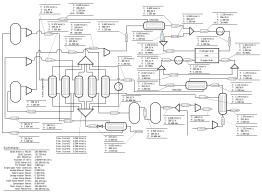

In [26]:
display(SVG(m.fs.write_pfd()))

In [27]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03, m.fs.product_flash04]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

fs.product_flash01
Diameter: 1.0296476234648757m
Height: 3.088942870394627m

fs.product_flash03
Diameter: 0.014017893282995705m
Height: 0.04205367984898711m

fs.product_flash04
Diameter: 1.5933505569530055m
Height: 4.7800516708590175m



In [28]:
print(df)

    cell_potential (V)  soec_current (MA)  soec_power (MW)  \
1             1.334185        -478.597878       638.537991   
2             1.324753        -466.632931       618.173566   
3             1.322279        -454.667984       601.197846   
4             1.319745        -442.703037       584.254993   
5             1.317113        -430.738090       567.330561   
6             1.314374        -418.773143       550.424536   
7             1.311513        -406.808196       533.534199   
8             1.308521        -394.843249       516.660779   
9             1.305380        -382.878302       499.801565   
10            1.302070        -370.913355       482.955237   
11            1.298571        -358.948408       466.119981   
12            1.294862        -346.983461       449.295722   
13            1.291188        -335.018514       432.571991   
14            1.287502        -323.053567       415.932203   
15            1.283711        -311.088620       399.347794   
16      

In [ ]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [ ]:
variables, constraints, jac, dh = check_scaling(m.fs)